## Delivery 데이터 분석

---



In [ ]:
adstrd_sub = pd.read_csv('/content/data/KT_data_20200717/adstrd_master.csv')

In [ ]:
delivery=delivery[['SERIAL_NUMBER','PROCESS_DT','DLVR_STORE_ID','DLVR_STORE_INDUTY_NM','DLVR_STORE_ADSTRD_CODE','DLVR_STORE_SIDO','DLVR_STORE_SIGUNGU',
                   'DLVR_DSTN_ADSTRD_CODE','DLVR_DSTN_SIDO','DLVR_DSTN_SIGUNGU','DLVR_REQUST_STTUS_VALUE','DLVR_MAN_ID','DLVR_RQESTER_ID','DLVR_RCEPT_CMPNY_ID','DLVR_AMOUNT',
                      'GOODS_AMOUNT','DLVR_RCEPT_TIME','DLVR_CARALC_TIME','DLVR_COMPT_TIME']]

In [ ]:
delivery = pd.merge(delivery, adstrd_sub, how='left', left_on='DLVR_STORE_ADSTRD_CODE', right_on='adstrd_code')
delivery = pd.merge(delivery, adstrd_sub, how='left', left_on='DLVR_DSTN_ADSTRD_CODE', right_on='adstrd_code')

In [ ]:
delivery = delivery.loc[(delivery['DLVR_REQUST_STTUS_VALUE']==1),:].copy()
delivery['week'] = pd.to_datetime(delivery['PROCESS_DT'], format='%Y-%m-%d').dt.weekofyear
delivery['week'] = delivery['week'].apply(lambda x : f'0{x}주차' if x < 10 else f'{x}주차')

In [ ]:
delivery_week_of_date = delivery.groupby(['week'])['PROCESS_DT'].max().reset_index()

In [ ]:
delivery_seoul = delivery[(delivery['DLVR_STORE_SIDO']=='서울특별시')&(delivery['DLVR_DSTN_SIDO']=='서울특별시')]
delivery_seoul.reset_index(inplace=True)

In [ ]:
delivery_seoul_1 = delivery_seoul[['PROCESS_DT','DLVR_STORE_SIGUNGU','GOODS_AMOUNT','DLVR_STORE_INDUTY_NM']]
delivery_all = delivery_seoul_1.groupby(['PROCESS_DT'], as_index=False).count()

In [ ]:
fig = px.line(delivery_all, x='PROCESS_DT', y='GOODS_AMOUNT', title = '일별 배달 변화율')
fig.update_layout(shapes=[
    dict(
      type= 'line',
      yref= 'paper', y0= 0, y1= 1,
      xref= 'x', x0= '2020-02-03', x1= '2020-02-03',
    )
])
fig.show()

코로나에 따른 배달 변화율을 시각화한 것이다.
코로나 전과 비교해봤을 때 이전과 다른 점이 눈에 띄지 않았다.

In [ ]:
covid_1 = time_province.copy()
covid_1['date'] = pd.to_datetime(covid_1['date'], format='%Y-%m-%d')
covid_2 = time_province.copy()
covid_2['date'] = pd.to_datetime(covid_2['date'], format='%Y-%m-%d') + pd.DateOffset(days=1)
covid_2 = covid_2.append(covid_1.loc[(covid_1['date']=='2020-01-20'),:], ignore_index=True)
covid_2['date'] = pd.to_datetime(covid_2['date'], format='%Y-%m-%d')
covid_2 = covid_2.loc[(covid_2['date']!='2020-07-01'),:].sort_values(by="date", ascending=True)
covid_2.loc[covid_2['date']=='2020-01-20', 'confirmed'] = 0

covid_day = pd.merge(covid_2, covid_1, on=['date', 'time', 'province'])
covid_day['confirmed_day'] = covid_day['confirmed_y'] - covid_day['confirmed_x']

In [ ]:
covid_day['week'] = pd.to_datetime(covid_day['date'], format='%Y%m%d').dt.weekofyear
covid_day['week'] = covid_day['week'].apply(lambda x : f'0{x}주차' if x < 10 else f'{x}주차')
covid_count = covid_day.groupby(['week'])['confirmed_x'].max().reset_index()

In [ ]:
delivery_count = delivery.groupby(['week'])['SERIAL_NUMBER'].count().reset_index()
delivery_man_count = delivery.groupby(['week'])['DLVR_MAN_ID'].nunique().reset_index()
delivery_requester_count = delivery.groupby(['week'])['DLVR_RQESTER_ID'].nunique().reset_index()
delivery_company_count = delivery.groupby(['week'])['DLVR_RCEPT_CMPNY_ID'].nunique().reset_index()
delivery_store_count = delivery.groupby(['week'])['DLVR_STORE_ID'].nunique().reset_index()
delivery_amount_mean = delivery.groupby(['week'])['DLVR_AMOUNT'].mean().reset_index()

In [ ]:
delivery_seoul_df = delivery.loc[(delivery['DLVR_DSTN_SIDO']=='서울특별시'),:].copy()
delivery_seoul_count = delivery_seoul_df.groupby(['week'])['SERIAL_NUMBER'].count().reset_index()
delivery_seoul_man_count = delivery_seoul_df.groupby(['week'])['DLVR_MAN_ID'].nunique().reset_index()
delivery_seoul_store_count = delivery_seoul_df.groupby(['week'])['DLVR_STORE_ID'].nunique().reset_index()

In [ ]:
fig = make_subplots(rows=2, cols=2, subplot_titles=("주별 누적 확진자수", "주별 호출수", "주별 평균배달비", "주별 상점수"))
fig.add_trace(go.Scatter(x = covid_count['week'], y = covid_count['confirmed_x']), row=1, col=1)
fig.add_trace(go.Scatter(x = delivery_seoul_count['week'], y = delivery_seoul_count['SERIAL_NUMBER']), row=1, col=2)
fig.add_trace(go.Scatter(x = delivery_seoul_man_count['week'], y = delivery_seoul_man_count['DLVR_MAN_ID']), row=2, col=1)
fig.add_trace(go.Scatter(x = delivery_seoul_store_count['week'], y = delivery_seoul_store_count['DLVR_STORE_ID']), row=2, col=2)
fig.update_layout(height=1000, width=1000, title_text="확진자에 따른 서울특별시 배달서비스 증감 지표", showlegend=False)
fig.show()

서울특별시로 한정하여 데이터를 분석해보았다. 8주차를 기준으로 확진자가 급증하였고 이와 비슷한 시기에 주별 상점수와 호출수가 감소한 것을 볼 수 있다.
반대로 같은 시기에 주별 평균배달비가 꾸준히 증가한 것으로 보아 배달비는 상점 수와 호출 수와는 반비례한다. 하지만 확진자가 급증한 것에 따른 시민들의 위기의식과 평균배달비용은 어느정도 비례관계가 있음을 알 수 있다.



In [ ]:
delivery_seoul_mean = delivery_seoul_df.groupby(['week'])['GOODS_AMOUNT'].sum().reset_index()

In [ ]:
delivery_every = delivery.loc[(delivery['DLVR_DSTN_SIDO'].isin(['서울특별시','경기도','경상남도','충청남도','제주특별자치도','대구광역시','전라북도','인천광역시'])) & (delivery['DLVR_STORE_SIDO'].isin(['서울특별시','경기도','경상남도','충청남도','제주특별자치도','대구광역시','전라북도','인천광역시'])),:]
delivery_every_mean =delivery_every.groupby(['DLVR_DSTN_SIDO','week'])['DLVR_AMOUNT'].mean().reset_index()
delivery_every_mean['DLVR_AMOUNT'] = delivery_every_mean['DLVR_AMOUNT']

In [ ]:
fig = px.line(delivery_every_mean, x = 'week', y = 'DLVR_AMOUNT', color = 'DLVR_DSTN_SIDO', title='확진자에 따른 전국 배달서비스 증감 지표').for_each_trace(lambda t: t.update(name=t.name.replace("DLVR_DSTN_SIDO=","")))
fig.show()

3~4주차에 전국적으로 배달비용이 눈에 띄게 증가하였다. 특히 대구광역시의 경우 신천지교회와 관련된 집단감염으로 시민들의 불안감이 커질 당시 배달비용 또한 마찬가지로 증가하여 이후 일정 시기동안 유지되었다. 

In [ ]:
def plot_trend(ind, color='green',title='text', amount=False, legend=True):
    
    card_ind = card[card['업종'].isin(ind)]
    num_category = len(ind)
    
    fig, ax = plt.subplots(1,1, figsize=(10,4))
    
    if amount==False:
        sns.lineplot(x='주', y='이동평균_건수_sc', data=card_ind, hue='업종',marker='>',linewidth=2, 
                palette=sns.light_palette("gray", num_category), ax=ax)
        sns.lineplot(x='주',y='이동평균_건수_sc', data=card_ind, ci='sd', color=color, alpha=0.1, ax=ax)
        plt.ylabel('이동평균_건수_sc')
        plt.title('판매건수 트렌드('+title+')', fontsize=12, weight='bold')
    else:
        sns.lineplot(x='주', y='이동평균_금액_sc', data=card_ind, hue='업종',marker='>',linewidth=2, 
                palette=sns.light_palette("gray", num_category), ax=ax)
        sns.lineplot(x='주',y='이동평균_금액_sc', data=card_ind, ci='sd', color=color, alpha=0.1, ax=ax)
        plt.ylabel('이동평균_금액_sc')
        plt.title('판매금액 트렌드('+title+')', fontsize=12, weight='bold')
    
    ax.axvline(11, c='darkgray')
    ax.text(11, 1.03, '2/24~3/15\n대확산', horizontalalignment='center', fontdict={'color':'gray', 'weight':'bold', 'size':9})
    ax.axvline(4, c='darkgray')
    ax.text(4, 1.03, '1/20~1/26\n설날', horizontalalignment='center', fontdict={'color':'gray', 'weight':'bold', 'size':9})
    
    if legend==True:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(loc='lower right', handles=handles[1:], frameon=False, bbox_to_anchor=(1.15, 0.2), fontsize=7, 
              title='주요 업종', title_fontsize=8)
    else:
        ax.legend().set_visible(False)
    plt.xlabel('이동평균 주')
    plt.xticks(list(range(4,25)))
    plt.ylim(-0.05, 1.13)
    plt.xlim(3,25)
    plt.tight_layout()

In [ ]:
#palette
pal = ['#50d890', '#007944','#888888','#f3c623','#EFEFEF', '#96bb7c', '#d9bf77','#3f3f44']

In [ ]:
fpop_df.columns = ['날짜','시간','성별','연령','행정동 코드','인구수']
remove = ['age_00','age_10','age_15','age_70'] #20대~60대만 확인
fpopl = fpop_df[~fpop_df['연령'].isin(remove)]

fpopl['날짜'] = fpopl['날짜'].astype('str').apply(lambda x: x[:4]+'-'+x[4:6]+'-'+x[6:])
fpopl = fpopl.groupby('날짜').sum().reset_index().drop(['시간','행정동 코드'], axis=1)
fpopl['주'] = pd.to_datetime(fpopl['날짜']).dt.week

In [ ]:
fpopl_1 = fpopl[~fpopl['주'].isin([1,2,3,25])].groupby('주').mean().reset_index() #트렌드 플롯과 기간을 맞춰줌(4~24주)
fpopl_1['인구수_sc'] = fpopl_1['인구수'].transform(lambda x:(x-x.min())/(x.max()-x.min()))
fpopl_1['이동평균'] = round(fpopl_1['인구수'].rolling(window=3, min_periods=1).mean())
fpopl_1['이동평균_sc'] = fpopl_1['이동평균'].transform(lambda x:(x-x.min())/(x.max()-x.min())) #minmax scaling

In [ ]:
delivery = delivery[delivery['DLVR_STORE_SIDO']=='서울특별시']
delivery = delivery[delivery['DLVR_REQUST_STTUS_VALUE']==1].reset_index(drop=True)

delivery_1 = delivery[['PROCESS_DT', 'SERIAL_NUMBER']].groupby('PROCESS_DT').count().reset_index().copy()
delivery_1['주'] = pd.to_datetime(delivery_1['PROCESS_DT']).dt.week
delivery_1 = delivery_1.groupby('주').mean().reset_index()
delivery_1 = delivery_1[~delivery_1['주'].isin([1,2,3,25])].reset_index(drop=True)
delivery_1['이동평균'] = round(delivery_1['SERIAL_NUMBER'].rolling(window=3, min_periods=1).mean())
delivery_1['이동평균_sc'] = delivery_1['이동평균'].transform(lambda x:(x-x.min())/(x.max()-x.min()))


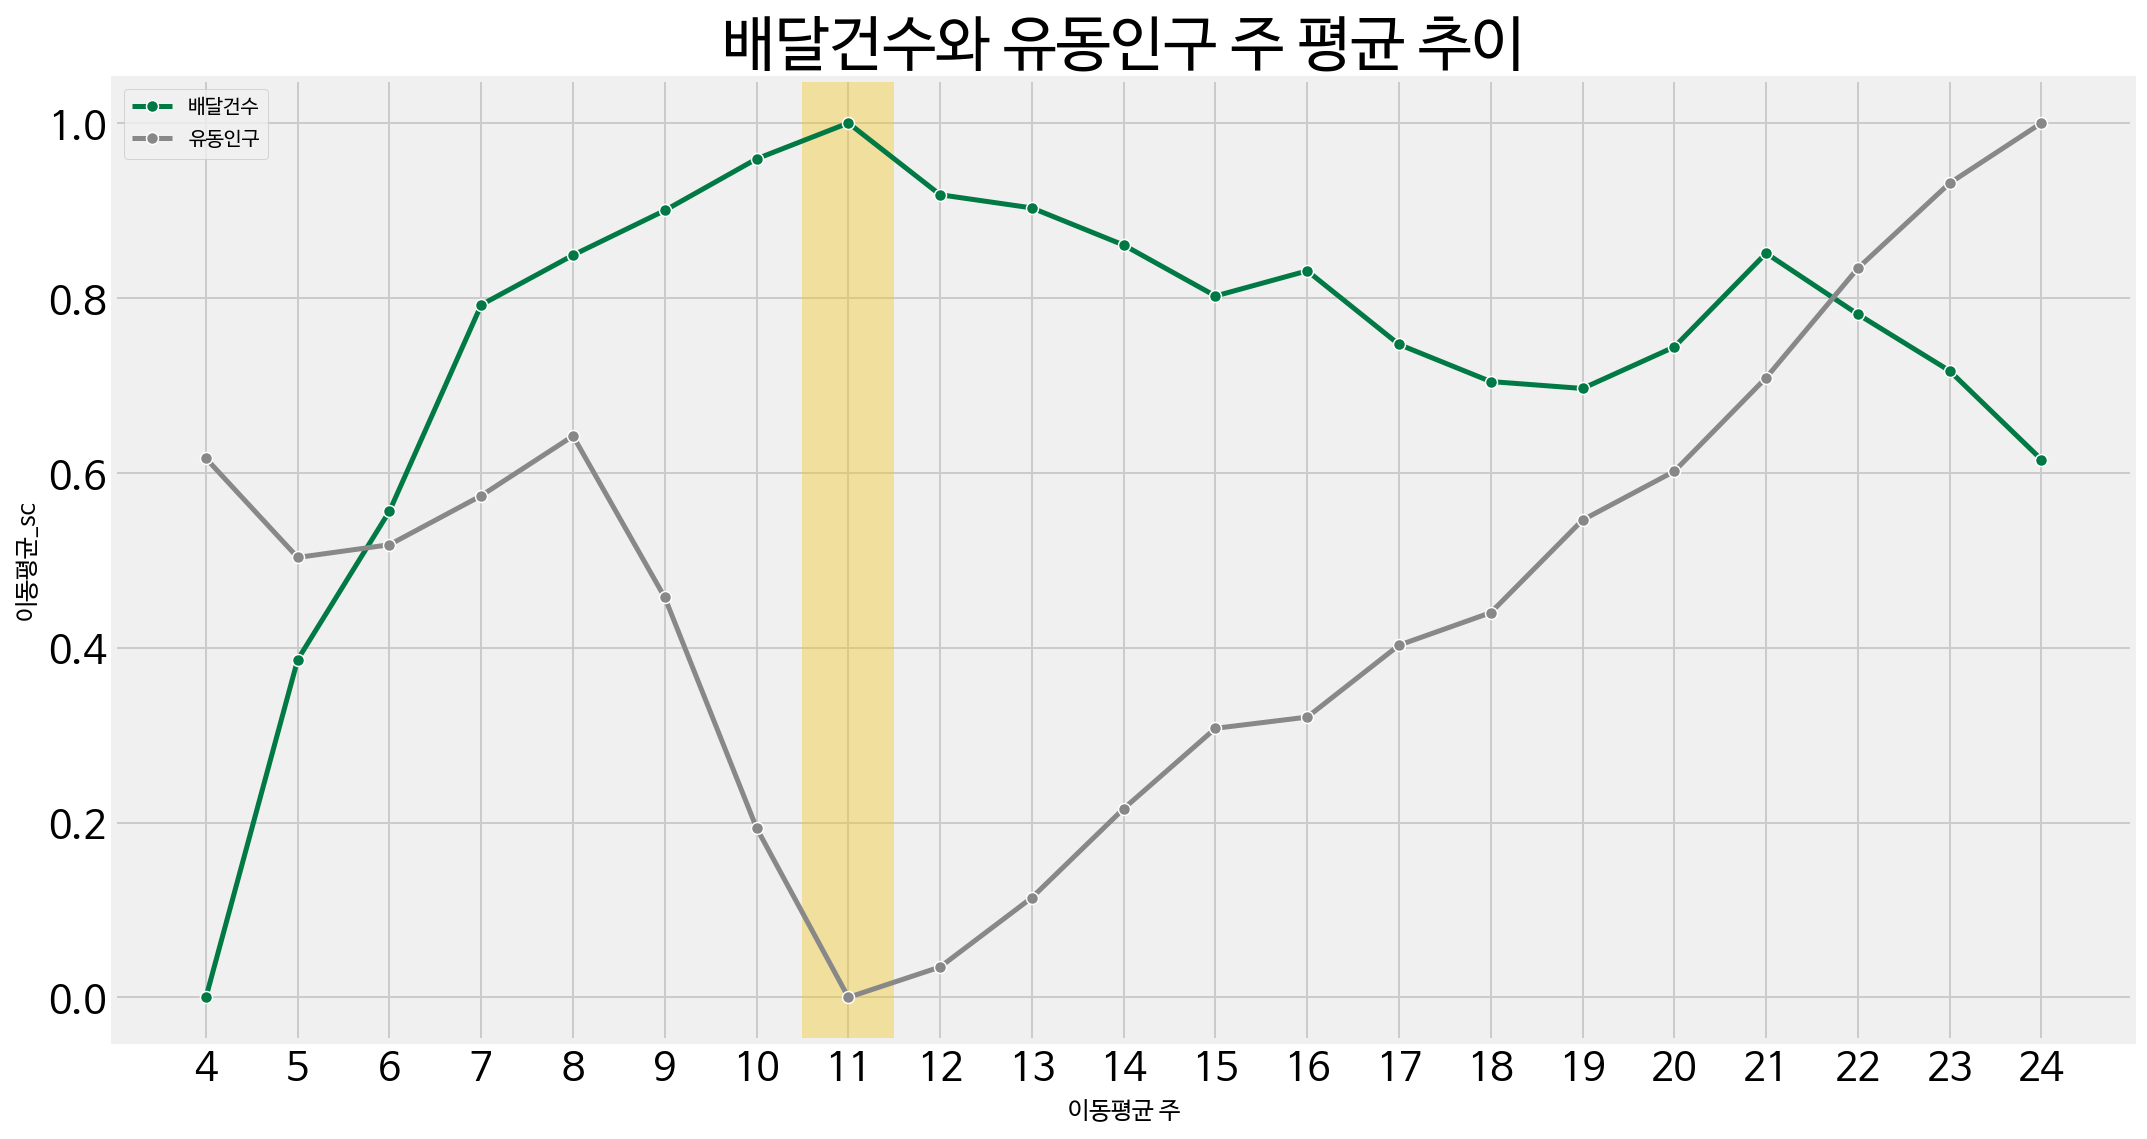

In [ ]:
plt.figure(figsize=(15,8))
sns.lineplot(x='주', y='이동평균_sc', color=pal[1], data=delivery_1, linewidth=2.5, marker='o', label='배달건수')
sns.lineplot(x='주', y='이동평균_sc', color=pal[2], data=fpopl_1, linewidth=2.5, marker='o', label='유동인구')
plt.xticks(list(range(4,25))); plt.legend(); plt.xlabel('이동평균 주')
plt.axvspan(10.5, 11.5, facecolor=pal[3], alpha=0.4)
plt.title('배달건수와 유동인구 주 평균 추이', fontsize=30)
plt.tight_layout()
plt.show()

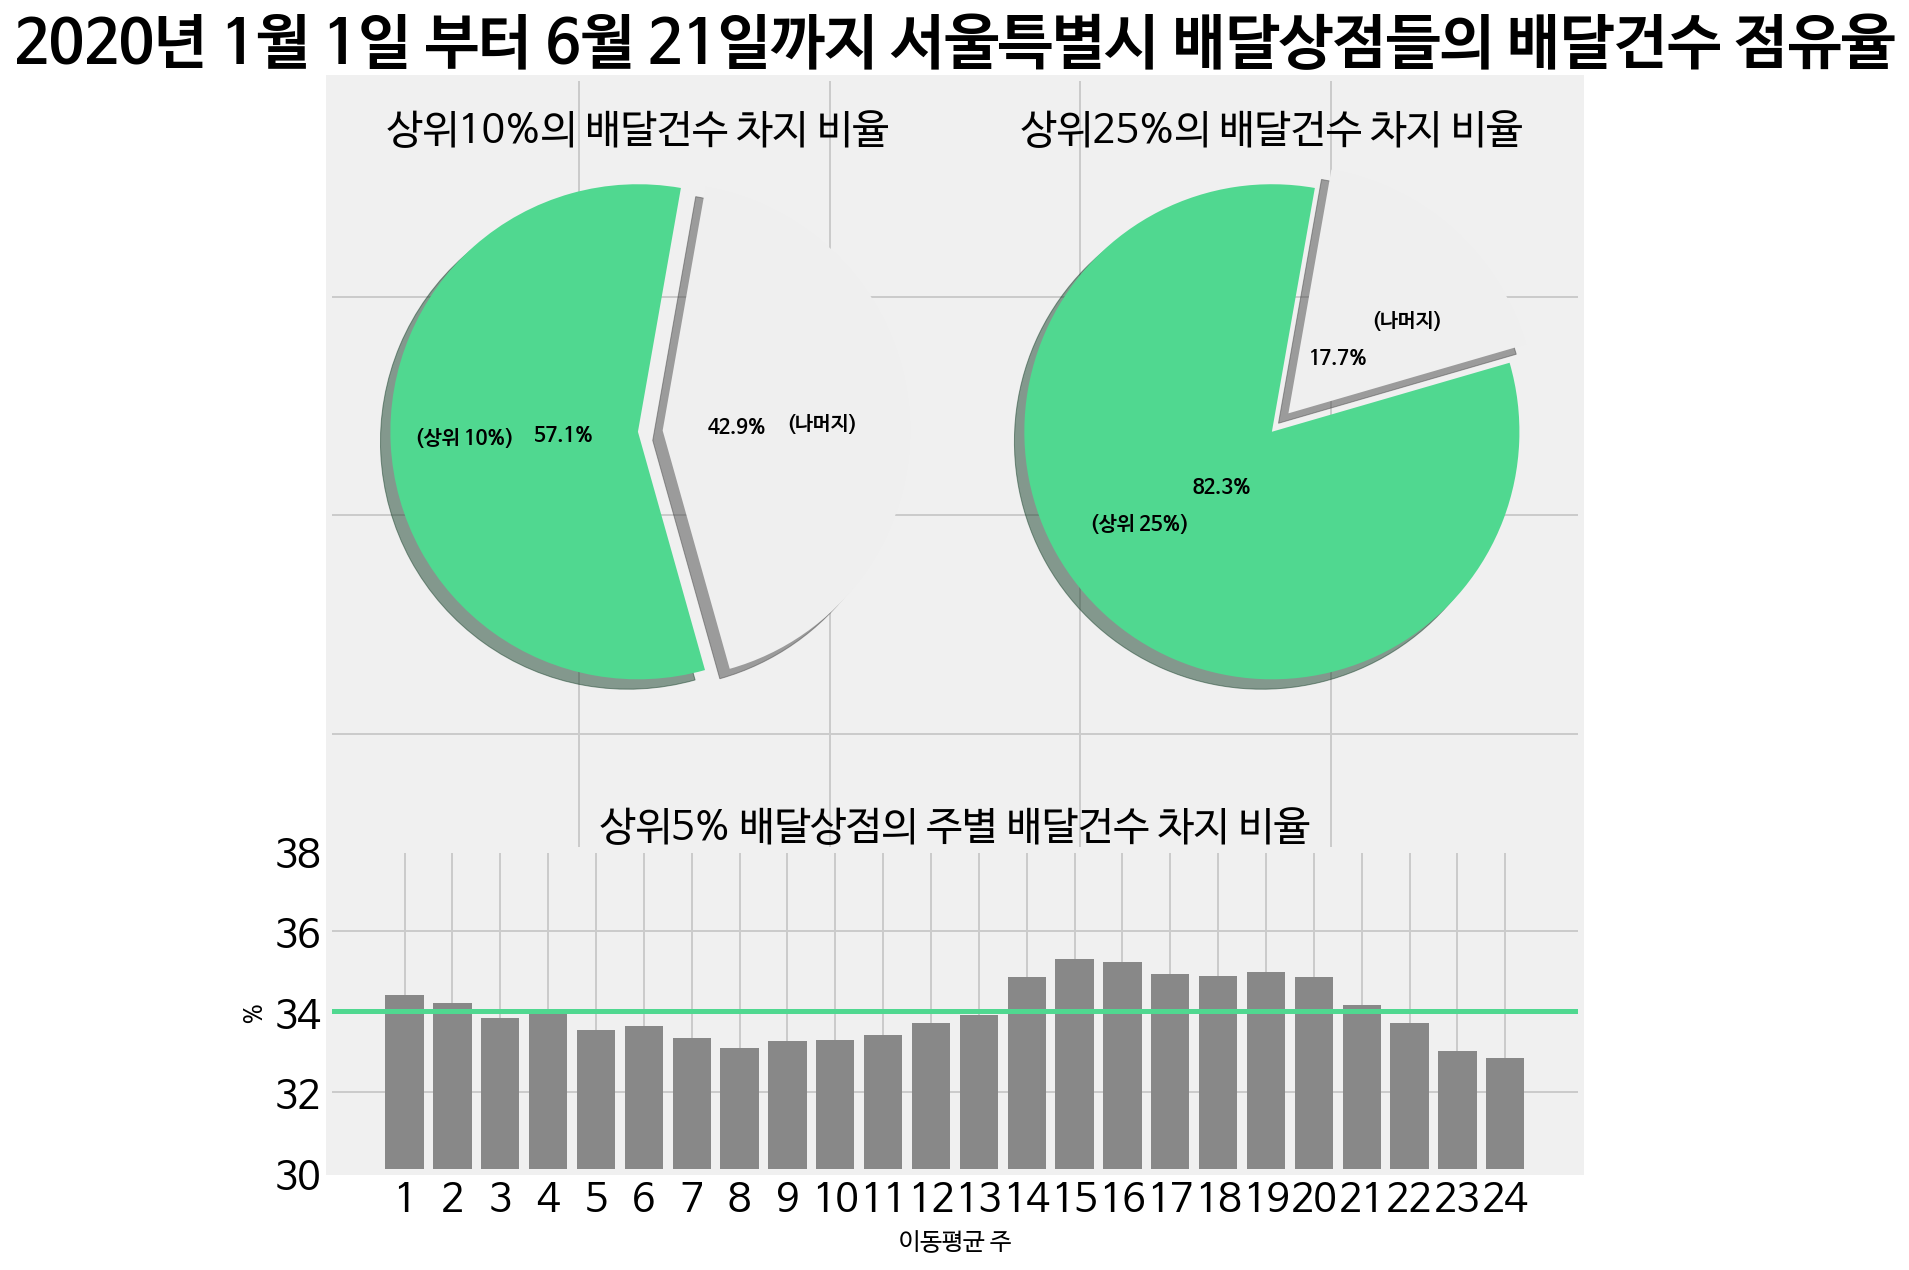

In [ ]:
delivery["주"] = pd.to_datetime(delivery['PROCESS_DT']).dt.week #주(week) 변수 생성
store_num = []
delivery_market = []
for i in list(range(1,25)):
    temp = delivery[delivery['주']==i] #각 주에서
    num = round(temp['DLVR_STORE_ID'].nunique()*5/100) #상위 5%의 배달건수를 차지하는 상점의 개수
    store_num.append(temp['DLVR_STORE_ID'].nunique()) 
    delivery_market.append(temp['DLVR_STORE_ID'].value_counts().head(num).sum()/temp.shape[0]*100) 
    
percent_top5 = list(pd.DataFrame(delivery_market).rolling(window=3, min_periods=1).mean()[0])

from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(10, 10))
plt.title('2020년 1월 1일 부터 6월 21일까지 서울특별시 배달상점들의 배달건수 점유율', weight='bold', fontsize=30)
ax=plt.gca()
ax.set_yticklabels([])
ax.set_xticklabels([])
gs = GridSpec(3, 4, figure=fig)
ax1 = fig.add_subplot(gs[:2, :2]) 
ax2 = fig.add_subplot(gs[:2, 2:]) 
ax3 = fig.add_subplot(gs[2:, :])

percent = [10,25] # 5%와 25%의 배달 비중 볼 것.
delivery['배달 시장 비중'] = ['(나머지)']*delivery.shape[0]

for num,p in enumerate(percent):
    ax = ax1 if num==0 else ax2
    i = round(delivery['DLVR_STORE_ID'].nunique()*p/100)
    store = delivery['DLVR_STORE_ID'].value_counts().head(i).index
    ind = delivery[delivery['DLVR_STORE_ID'].isin(store)].index
    delivery.loc[ind,'배달 시장 비중'] = delivery.loc[ind,'배달 시장 비중'].apply(lambda x: '(상위 '+str(p)+'%)')
    delivery['배달 시장 비중'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',shadow=True, startangle=80,
                                             labels=delivery['배달 시장 비중'].value_counts().index, colors=[pal[0], pal[4]],
                                             textprops={'weight':'bold', 'fontsize':10},labeldistance=0.5, pctdistance=0.3, ax=ax)
    ax.axis('off')
    ax.set_title('상위'+str(p)+'%의 배달건수 차지 비율', fontsize=20, position=(0.5, 0.95))

x = list(range(1,25))    
ax3.bar(x, percent_top5, color=pal[2])
ax3.set_ylim(30,38); ax3.set_xticks(x)
ax3.axhline(34,color=pal[0], linewidth=2.5)
ax3.set_title('상위5% 배달상점의 주별 배달건수 차지 비율', fontsize=20)
ax3.set_ylabel('%'); ax3.set_xlabel('이동평균 주')
plt.subplots_adjust(top = 0.96, wspace=0.05, bottom=0.2)

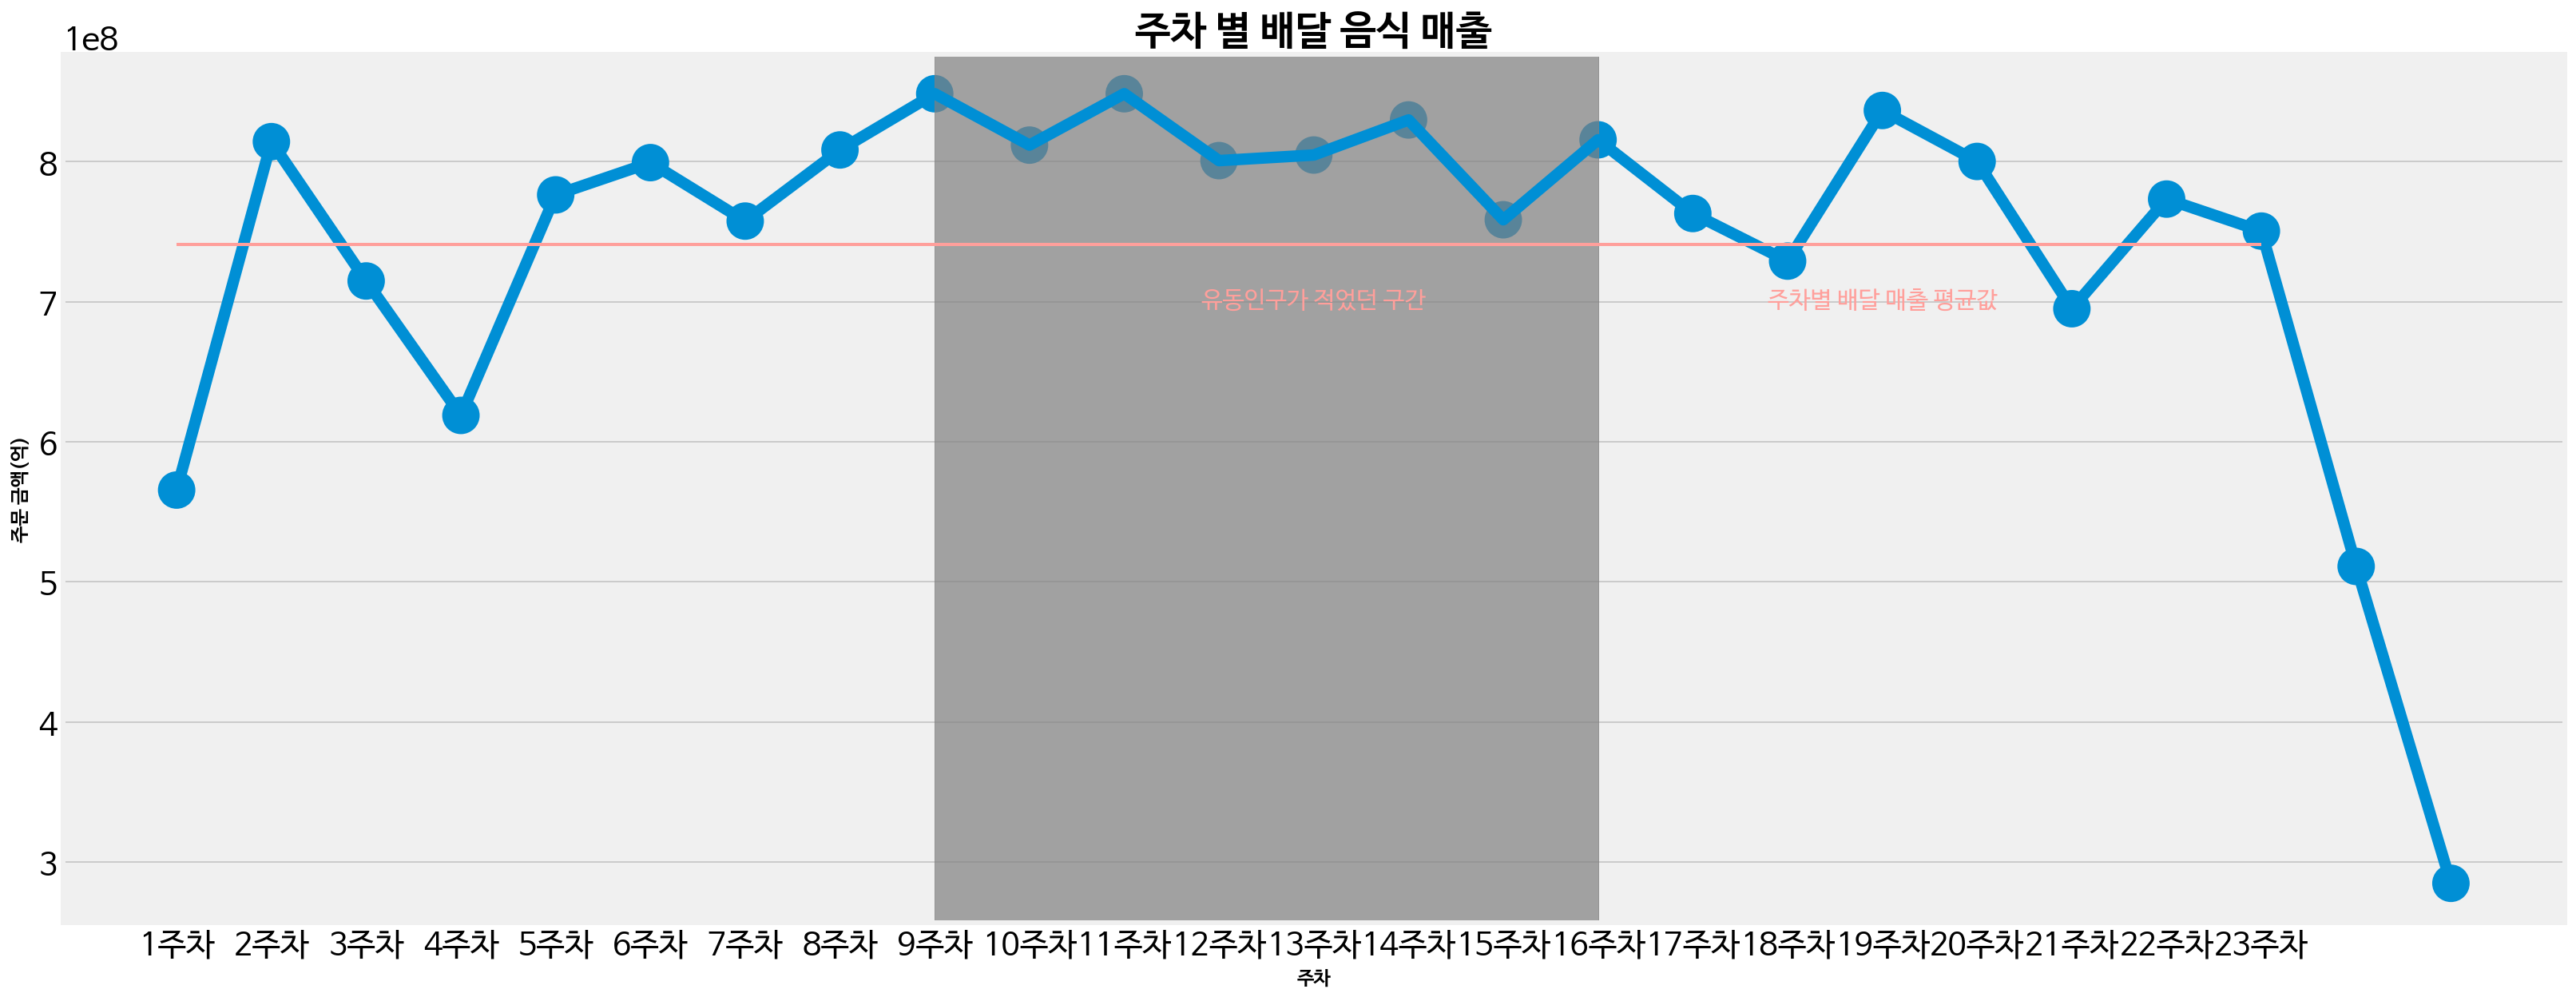

In [ ]:
fig = plt.figure(figsize = (25,10))
ax = sns.pointplot(x = 'week', y = 'GOODS_AMOUNT', data =delivery_seoul_mean, ci = False)
plt.plot([0,22],[delivery_seoul_mean['GOODS_AMOUNT'].mean(), delivery_seoul_mean['GOODS_AMOUNT'].mean()], color = 'r',linewidth = 2)
plt.title('주차 별 배달 음식 매출', fontsize = 25, fontweight = 'bold')
plt.xlabel('주차', fontsize = 12, fontweight = 'bold')
plt.ylabel('주문 금액(억)', fontsize = 12, fontweight = 'bold')
plt.xticks(np.arange(0,23),[f'{x}주차' for x in np.arange(1,26)])
plt.axvspan(8, 15, color='gray', alpha = 0.7)


ax.annotate('유동인구가 적었던 구간', xy = (12,7*10**8), xytext = (12, 7*10**8), va = 'center', ha = 'center', fontsize = 15, color = 'r')
plt.annotate('주차별 배달 매출 평균값', xy = (18, 7*10**8), xytext = (18, 7*10**8), va = 'center', ha = 'center', fontsize = 15, arrowprops=dict(facecolor='red'), color ='r')
fig.show()

이번엔 서울을 기준으로 하여 주차 별 배달 음식 매출 그래프를 시각화하였다.
유동인구가 적었던 9~16주차를 제외했을 때 배달 매출 평균값을 나타내는 붉은 선을 중심으로 그래프가 크게 변동하였다. 반대로 유동인구가 적었던 구간에서는 배달 음식 매출값이 평균을 상회하는 것을 볼 수 있다.

In [ ]:
delivery_ud = delivery.loc[(delivery['DLVR_STORE_SIGUNGU'].isin(['은평구','영등포구','노원구','구로구','관악구','용산구'])) & (delivery['DLVR_DSTN_SIGUNGU'].isin(['은평구','노원구','영등포구','구로구','관악구','용산구'])),:]
delivery_ud_mean =delivery_ud.groupby(['DLVR_STORE_SIGUNGU','week'])['DLVR_AMOUNT'].mean().reset_index()
delivery_ud_mean['DLVR_AMOUNT'] = delivery_ud_mean['DLVR_AMOUNT']

In [ ]:
fig = px.line(delivery_ud_mean, x = 'week', y = 'DLVR_AMOUNT', color = 'DLVR_STORE_SIGUNGU', title='유동인구에 따른 평균 배달비용 비교').for_each_trace(lambda t: t.update(name=t.name.replace("DLVR_STORE_SIGUNGU=","")))
fig.show()

유동인구가 큰 은평구, 구로구, 노원구는 3~5주차 당시 배달 비용이 크게 증가하였고 반대로 유동인구가 작았던 영등포구와 관악구는 다른 구에 비해 배달비용의 변화가 작은 것을 볼 수 있다. 이 그래프를 통해 마찬가지로 유동인구와 배달 비용 또한 어느정도 연관성이 있음을 알 수 있다.   

집단감염의 유무에 따른 유동인구 변화와 배달 비용의 연관성을 찾아보았다.

집단감염 발생 구

1. 구로구

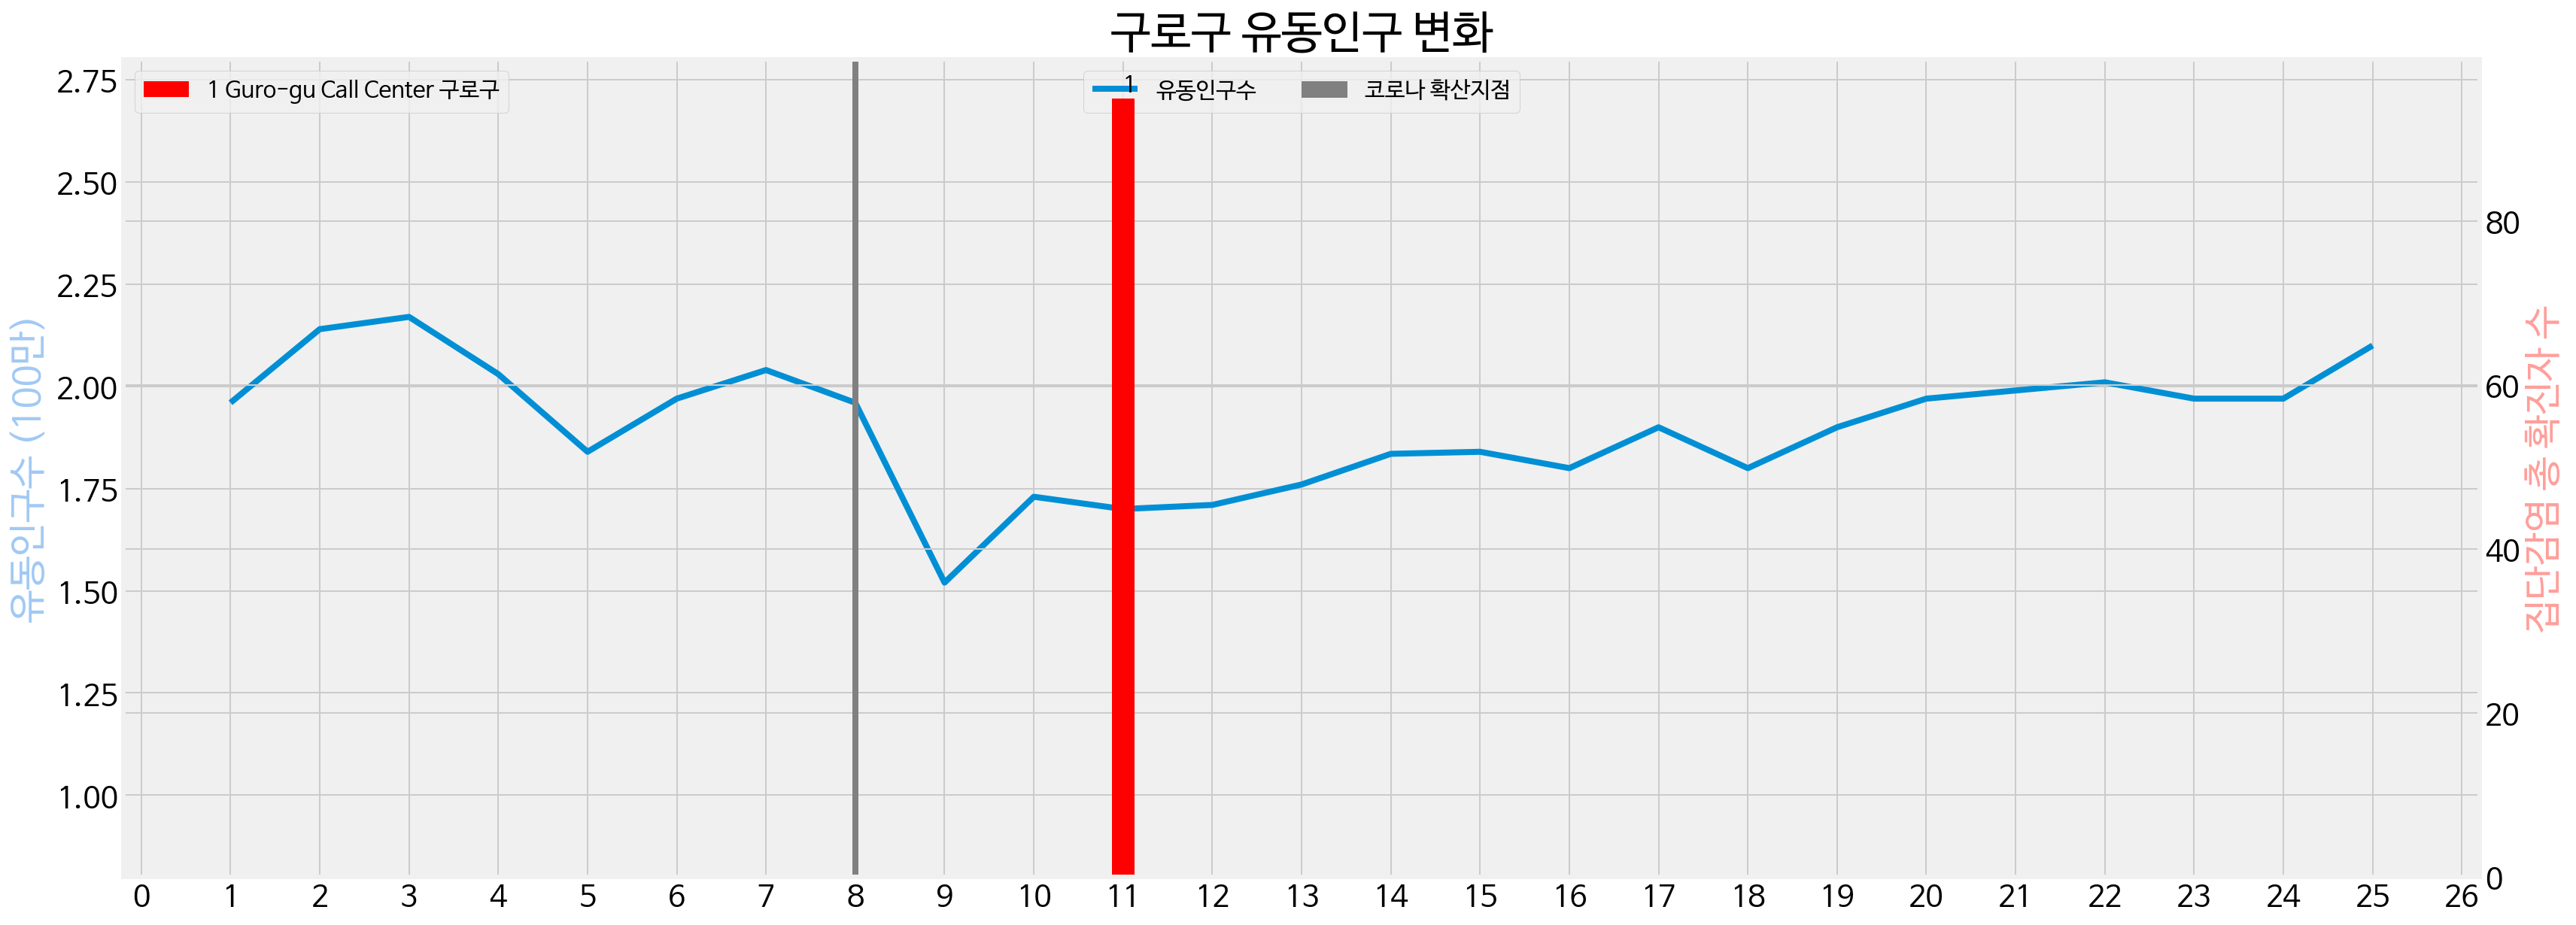

In [ ]:
plot_fpop_gu(new_fpop_seoul_gu,covid_case_seoul_mass_sorted_with_date,time_bin="주차", region="구로구")

delivery_ud = delivery.loc[(delivery['DLVR_STORE_SIGUNGU'].isin(['구로구'])) & (delivery['DLVR_DSTN_SIGUNGU'].isin(['구로구'])),:]
delivery_ud_mean =delivery_ud.groupby(['DLVR_STORE_SIGUNGU','week'])['DLVR_AMOUNT'].mean().reset_index()
delivery_ud_mean['DLVR_AMOUNT'] = delivery_ud_mean['DLVR_AMOUNT']

fig = px.line(delivery_ud_mean, x = 'week', y = 'DLVR_AMOUNT', color = 'DLVR_STORE_SIGUNGU', title='구로구의 집단감염에 따른 평균 배달비용 비교').for_each_trace(lambda t: t.update(name=t.name.replace("DLVR_STORE_SIGUNGU=","")))
fig.update_layout(shapes=[
    dict(
      type= 'line',
      yref= 'paper', y0= 0, y1= 1,
      xref= 'x', x0= '11주차', x1="11주차"
    )
])
fig.add_annotation(
            x='11주차',
            y= 3580,
            text="집단감염")
fig.show()

2. 관악구

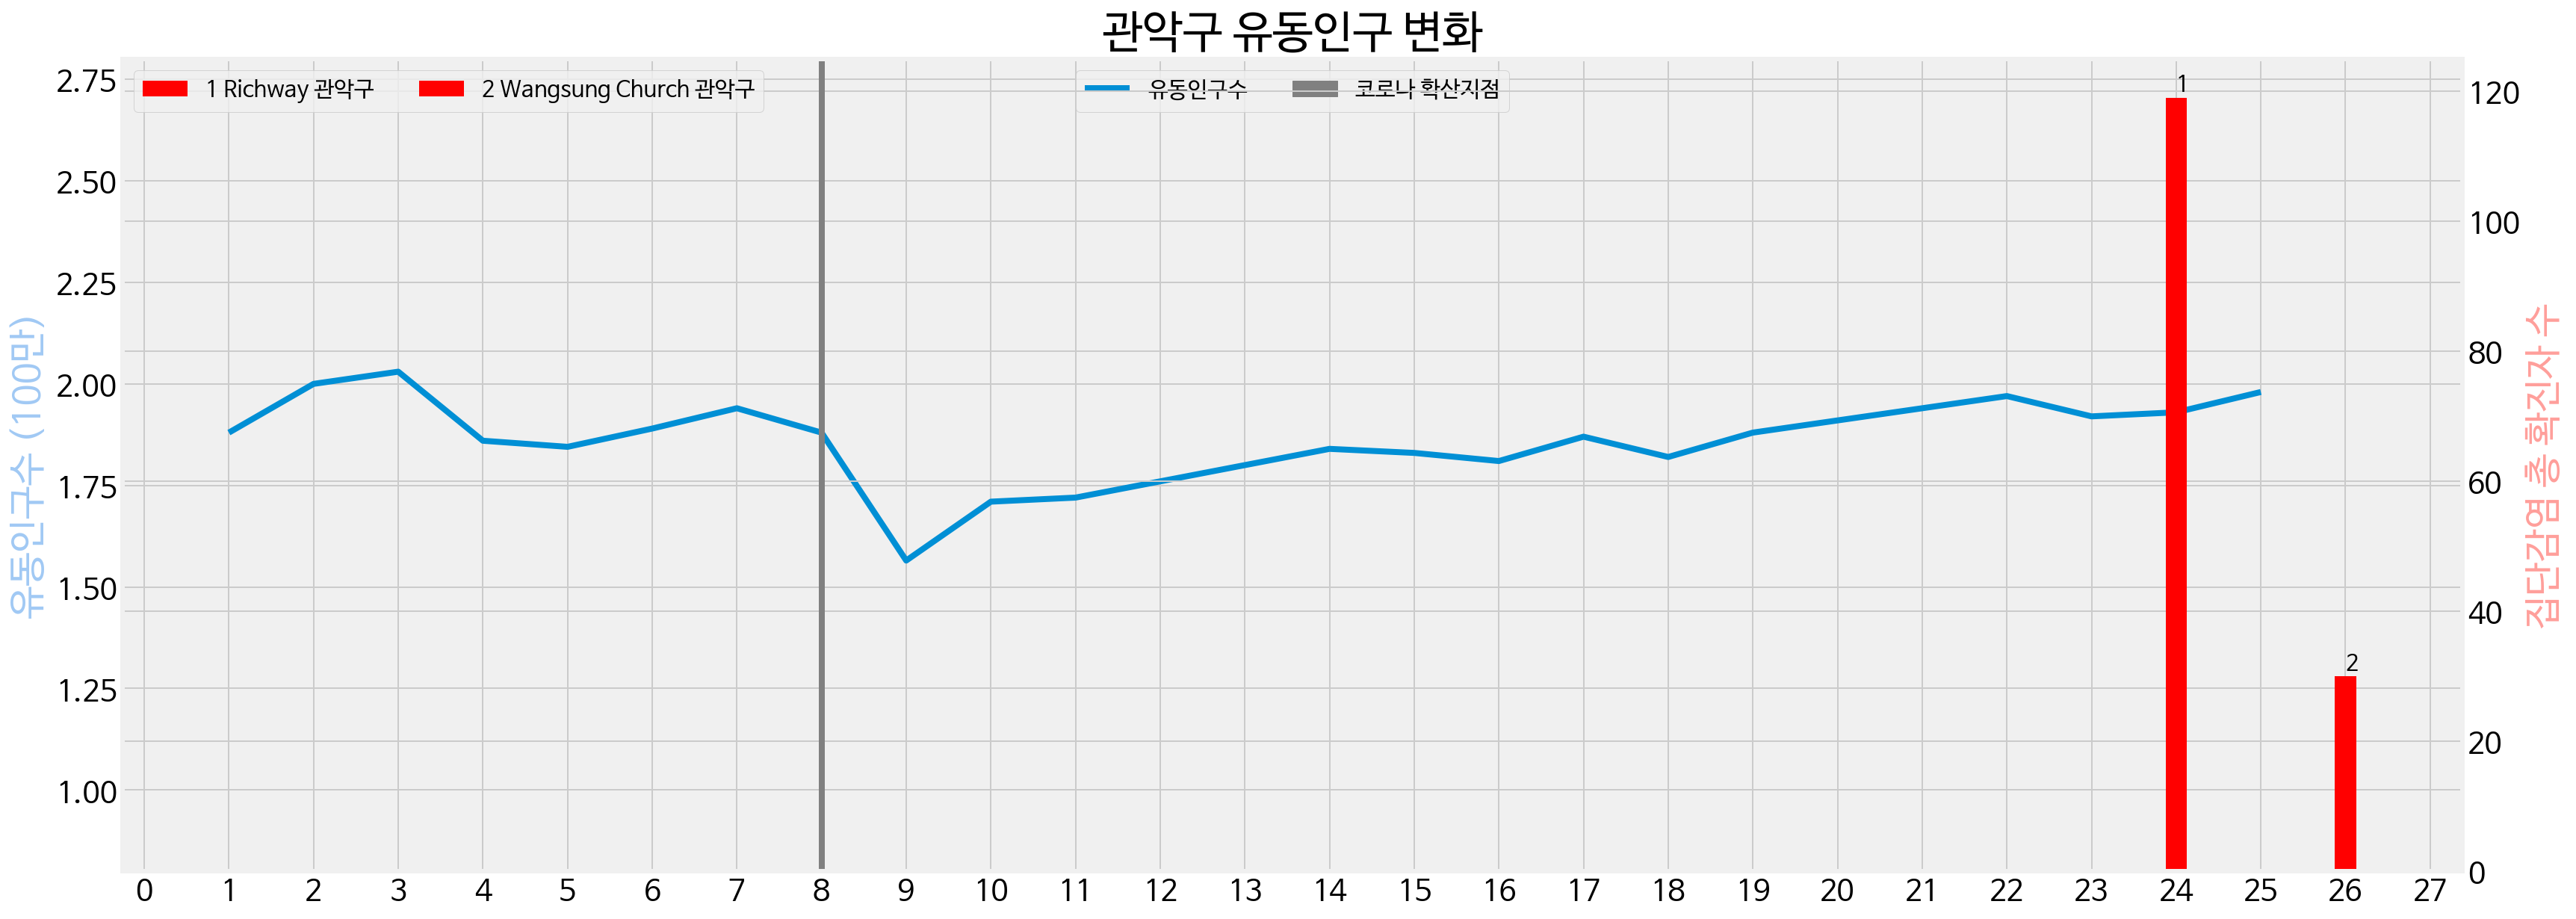

In [ ]:
plot_fpop_gu(new_fpop_seoul_gu,covid_case_seoul_mass_sorted_with_date,time_bin="주차", region="관악구")

delivery_ud = delivery.loc[(delivery['DLVR_STORE_SIGUNGU'].isin(['관악구'])) & (delivery['DLVR_DSTN_SIGUNGU'].isin(['관악구'])),:]
delivery_ud_mean =delivery_ud.groupby(['DLVR_STORE_SIGUNGU','week'])['DLVR_AMOUNT'].mean().reset_index()
delivery_ud_mean['DLVR_AMOUNT'] = delivery_ud_mean['DLVR_AMOUNT']

fig = px.line(delivery_ud_mean, x = 'week', y = 'DLVR_AMOUNT', color = 'DLVR_STORE_SIGUNGU', title='관악구의 집단감염에 따른 평균 배달비용 비교').for_each_trace(lambda t: t.update(name=t.name.replace("DLVR_STORE_SIGUNGU=","")))
fig.update_layout(shapes=[
    dict(
      type= 'line',
      yref= 'paper', y0= 0, y1= 1,
      xref= 'x', x0= '23주차', x1= '23주차',
    )
])
fig.add_annotation(
            x='23주차',
            y= 3415,
            text="집단감염")
fig.show()

3. 은평구

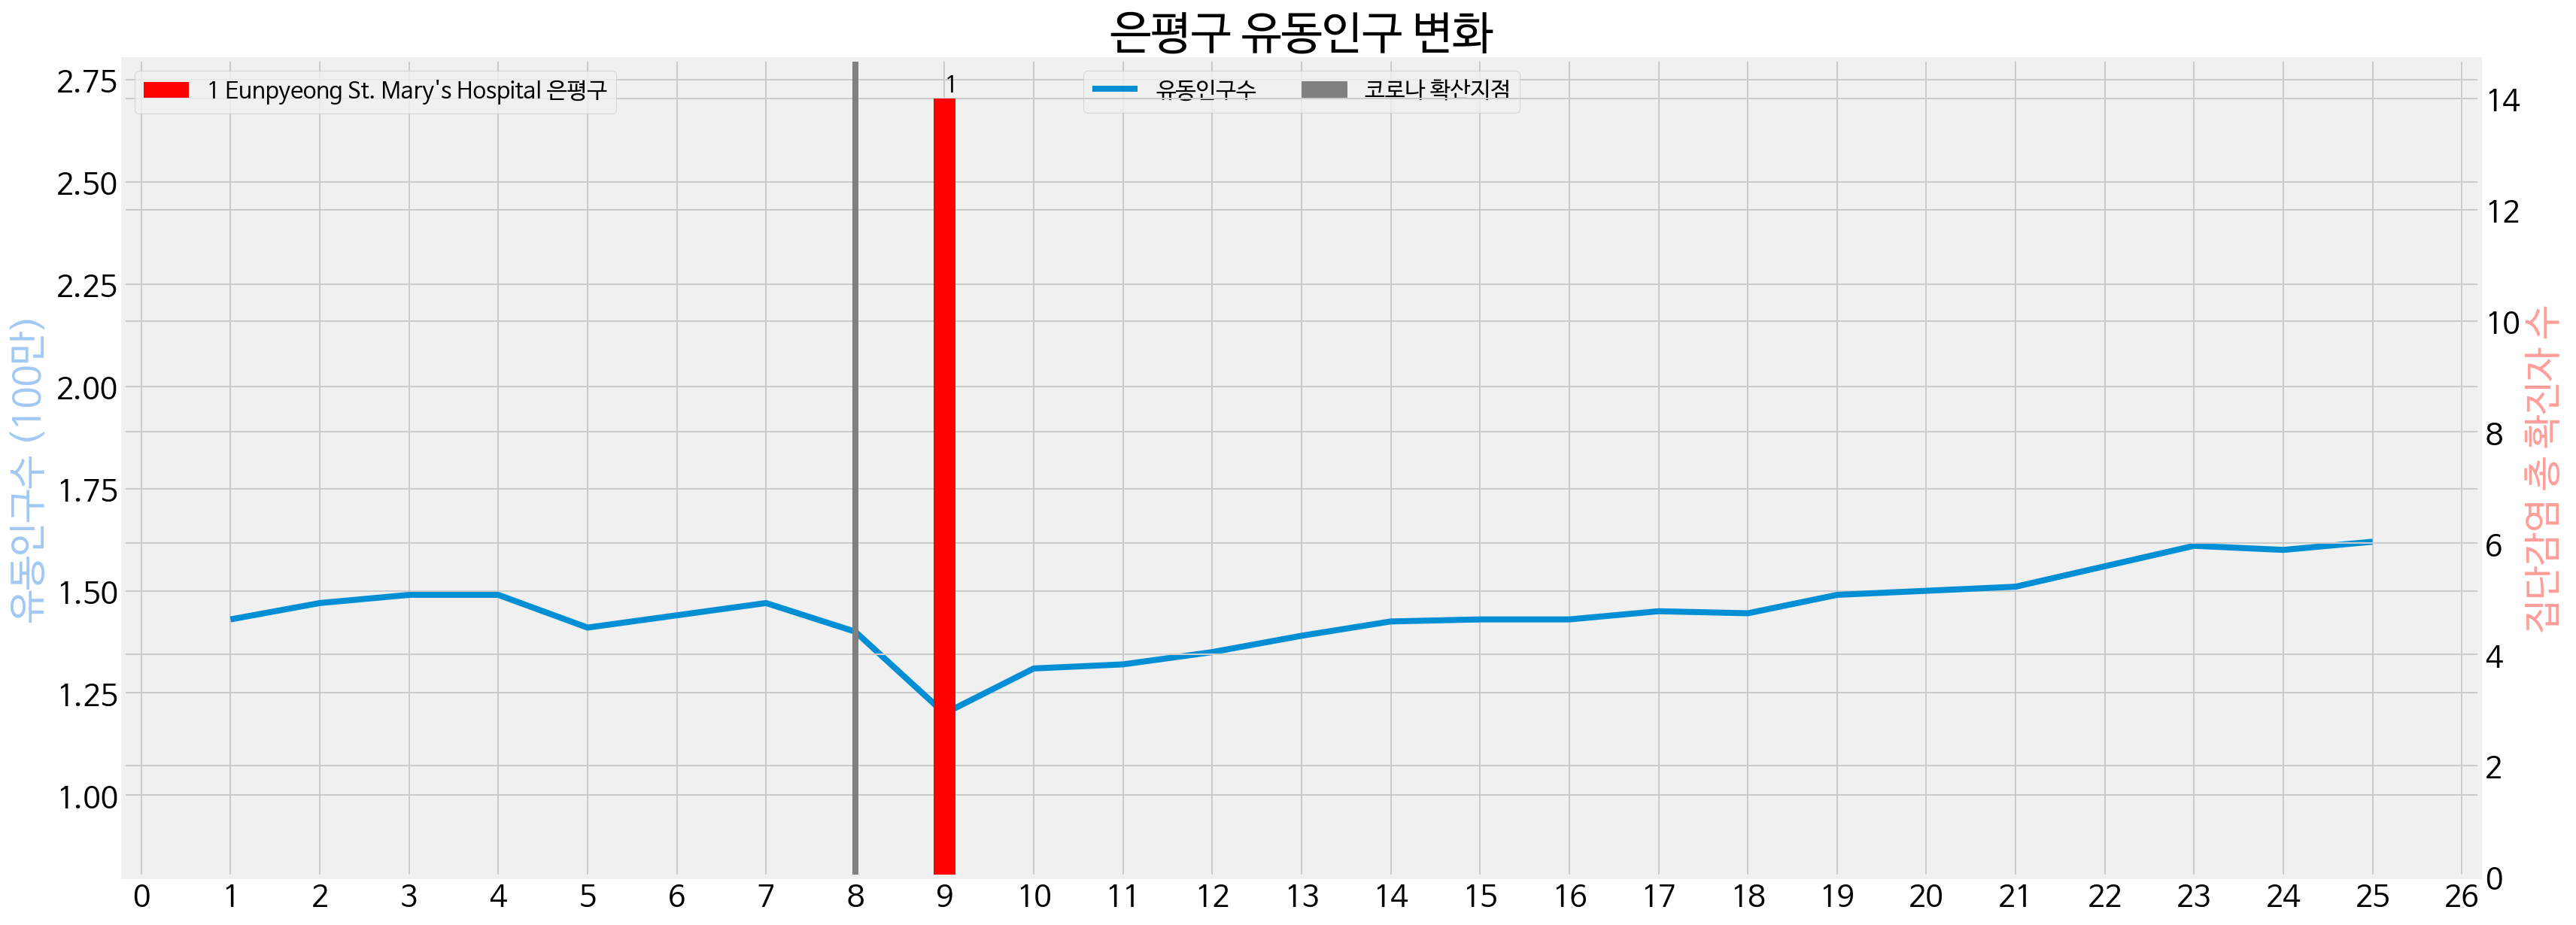

In [ ]:
plot_fpop_gu(new_fpop_seoul_gu,covid_case_seoul_mass_sorted_with_date,time_bin="주차", region="은평구")

delivery_ud = delivery.loc[(delivery['DLVR_STORE_SIGUNGU'].isin(['은평구'])) & (delivery['DLVR_DSTN_SIGUNGU'].isin(['은평구'])),:]
delivery_ud_mean =delivery_ud.groupby(['DLVR_STORE_SIGUNGU','week'])['DLVR_AMOUNT'].mean().reset_index()
delivery_ud_mean['DLVR_AMOUNT'] = delivery_ud_mean['DLVR_AMOUNT']

fig = px.line(delivery_ud_mean, x = 'week', y = 'DLVR_AMOUNT', color = 'DLVR_STORE_SIGUNGU', title='은평구의 집단감염에 따른 평균 배달비용 비교').for_each_trace(lambda t: t.update(name=t.name.replace("DLVR_STORE_SIGUNGU=","")))
fig.update_layout(shapes=[
    dict(
      type= 'line',
      yref= 'paper', y0= 0, y1= 1,
      xref= 'x', x0= '8주차', x1= '9주차',
    )
])
fig.add_annotation(
            x='13주차',
            y= 3711,
            text="집단감염")
fig.show()

4. 양천구

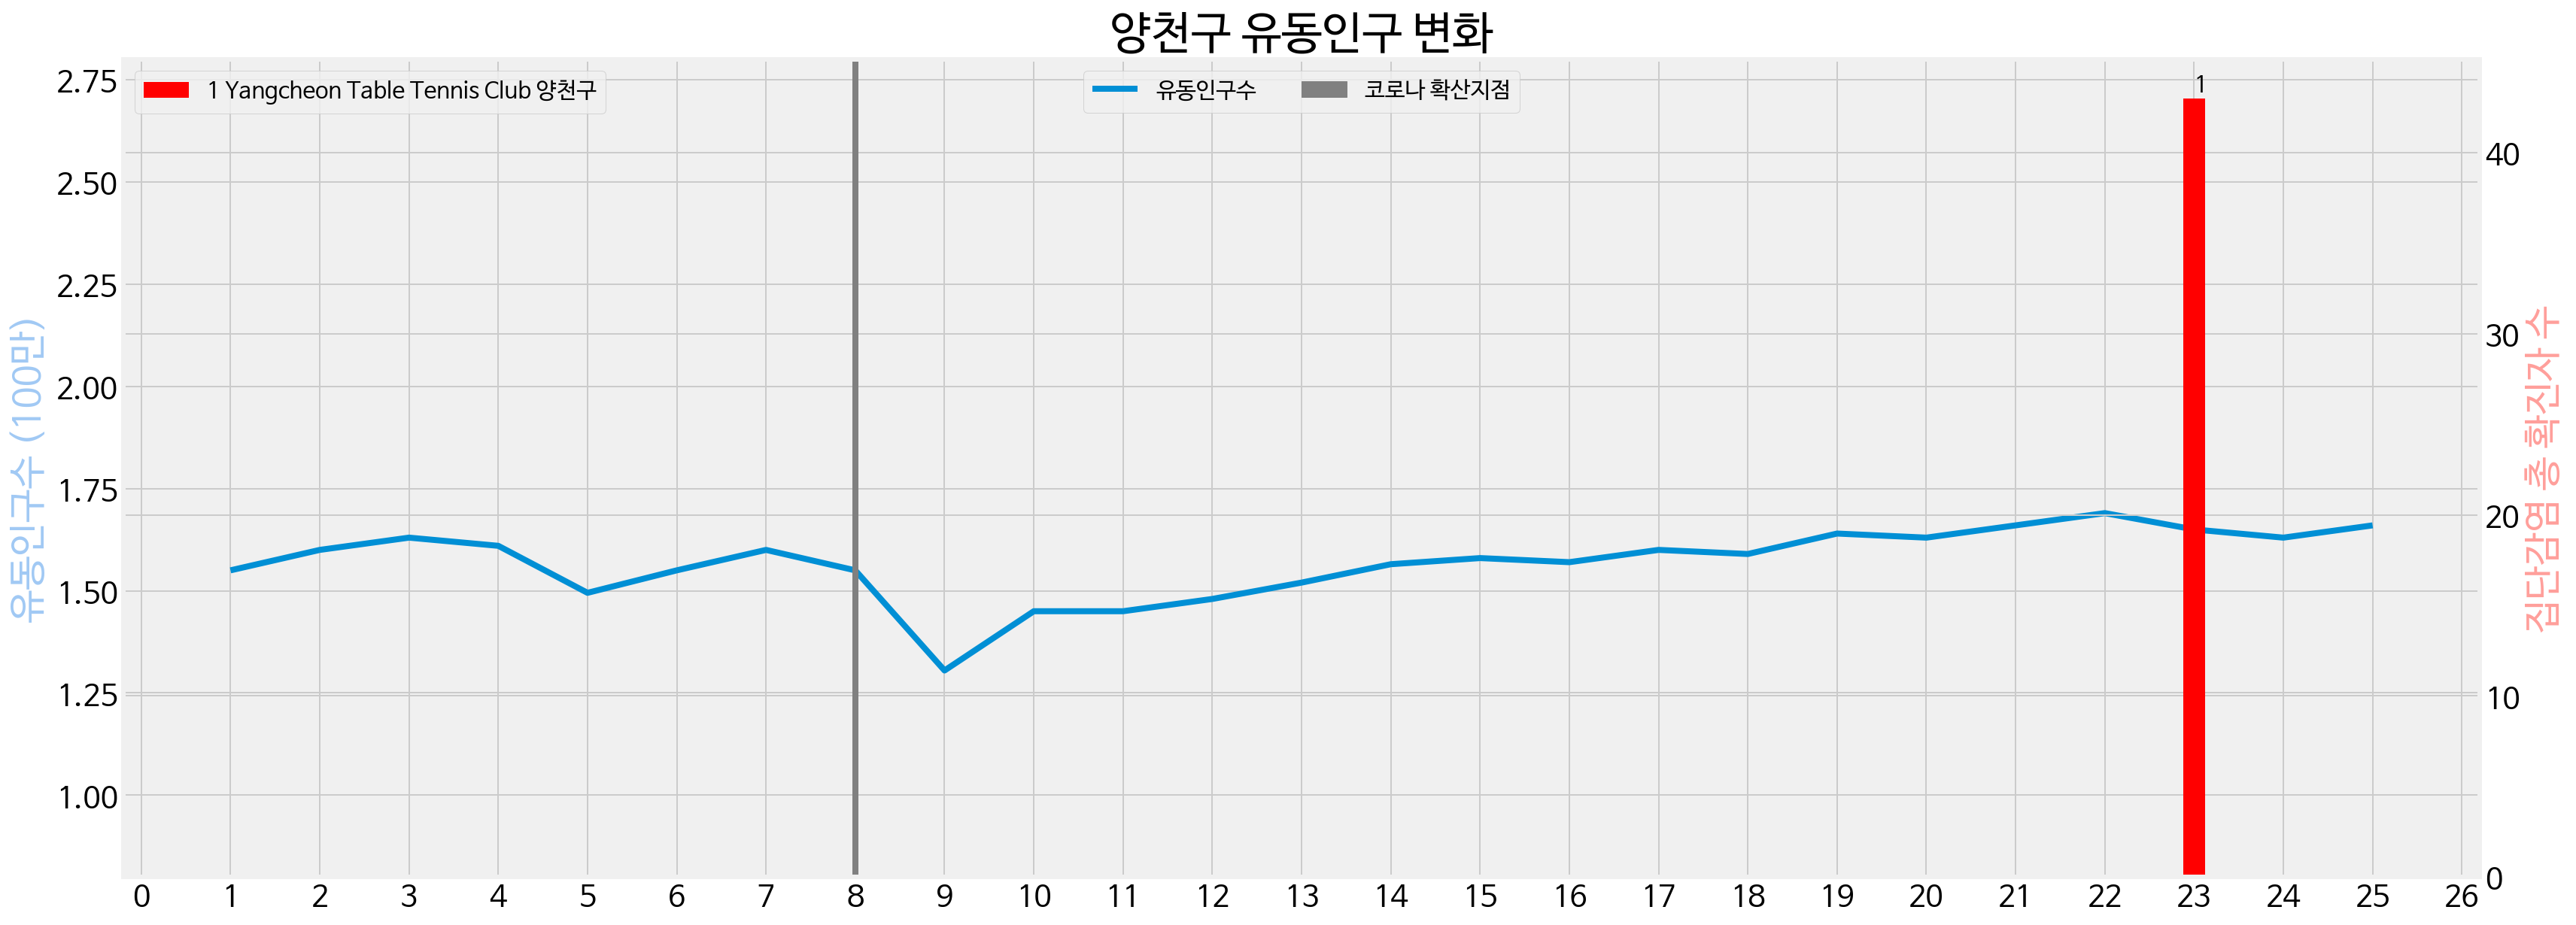

In [ ]:
plot_fpop_gu(new_fpop_seoul_gu,covid_case_seoul_mass_sorted_with_date,time_bin="주차", region="양천구")

delivery_ud = delivery.loc[(delivery['DLVR_STORE_SIGUNGU'].isin(['양천구'])) & (delivery['DLVR_DSTN_SIGUNGU'].isin(['양천구'])),:]
delivery_ud_mean =delivery_ud.groupby(['DLVR_STORE_SIGUNGU','week'])['DLVR_AMOUNT'].mean().reset_index()
delivery_ud_mean['DLVR_AMOUNT'] = delivery_ud_mean['DLVR_AMOUNT']

fig = px.line(delivery_ud_mean, x = 'week', y = 'DLVR_AMOUNT', color = 'DLVR_STORE_SIGUNGU', title='양천구의 집단감염에 따른 평균 배달비용 비교').for_each_trace(lambda t: t.update(name=t.name.replace("DLVR_STORE_SIGUNGU=","")))
fig.update_layout(shapes=[
    dict(
      type= 'line',
      yref= 'paper', y0= 0, y1= 1,
      xref= 'x', x0= '23주차', x1= '23주차',
    )
])
fig.add_annotation(
            x='23주차',
            y= 3466,
            text="집단감염")
fig.show()

5. 도봉구

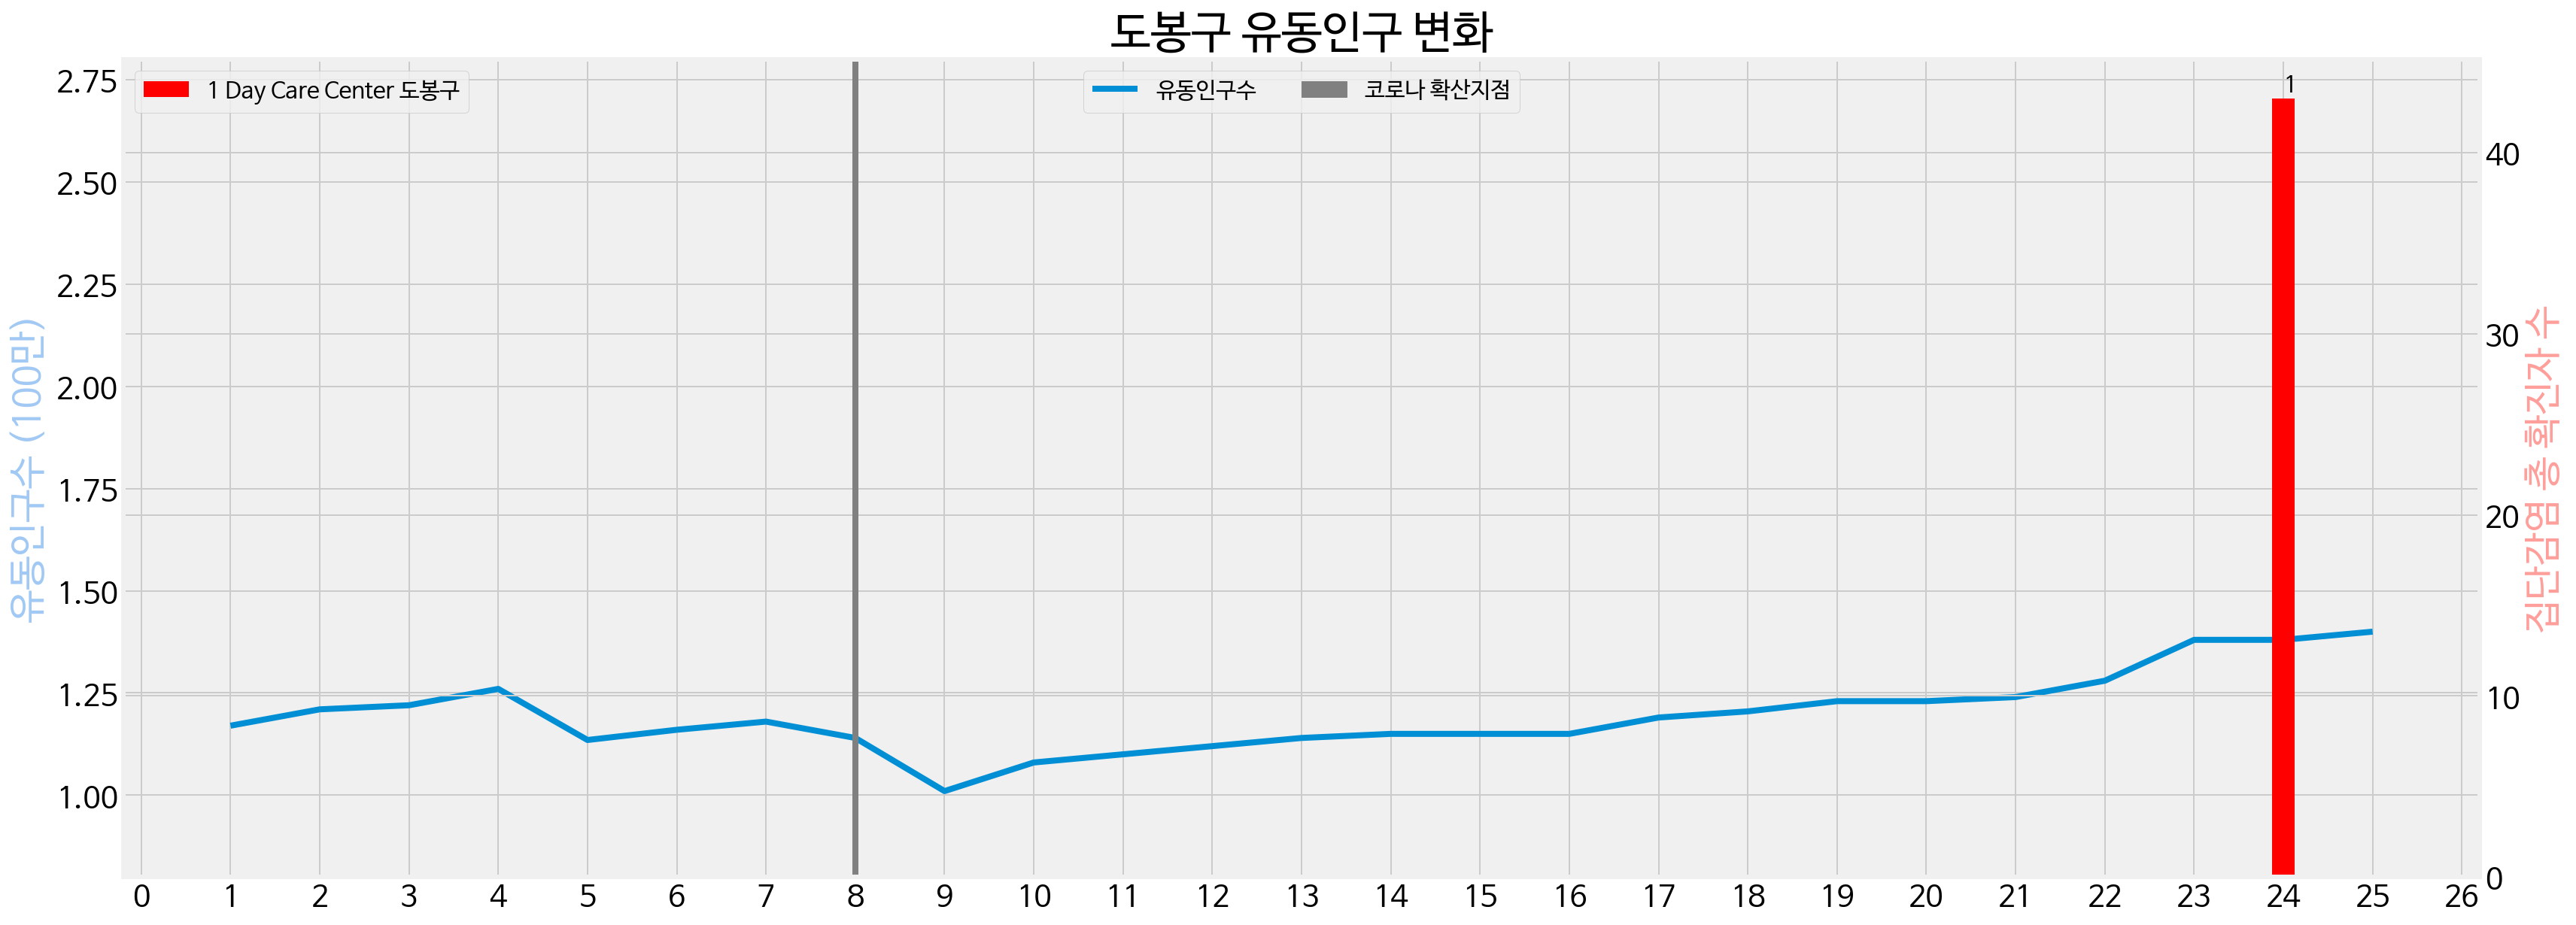

In [ ]:
plot_fpop_gu(new_fpop_seoul_gu,covid_case_seoul_mass_sorted_with_date,time_bin="주차", region="도봉구")

delivery_ud = delivery.loc[(delivery['DLVR_STORE_SIGUNGU'].isin(['도봉구'])) & (delivery['DLVR_DSTN_SIGUNGU'].isin(['도봉구'])),:]
delivery_ud_mean =delivery_ud.groupby(['DLVR_STORE_SIGUNGU','week'])['DLVR_AMOUNT'].mean().reset_index()
delivery_ud_mean['DLVR_AMOUNT'] = delivery_ud_mean['DLVR_AMOUNT']

fig = px.line(delivery_ud_mean, x = 'week', y = 'DLVR_AMOUNT', color = 'DLVR_STORE_SIGUNGU', title='도봉구의 집단감염에 따른 평균 배달비용 비교').for_each_trace(lambda t: t.update(name=t.name.replace("DLVR_STORE_SIGUNGU=","")))
fig.update_layout(shapes=[
    dict(
      type= 'line',
      yref= 'paper', y0= 0, y1= 1,
      xref= 'x', x0= '24주차', x1= '24주차',
    )
])
fig.add_annotation(
            x='24주차',
            y= 3477,
            text="집단감염")
fig.show()

집단감염 미발생 구

AttributeError: ignored

1. 노원구

No handles with labels found to put in legend.


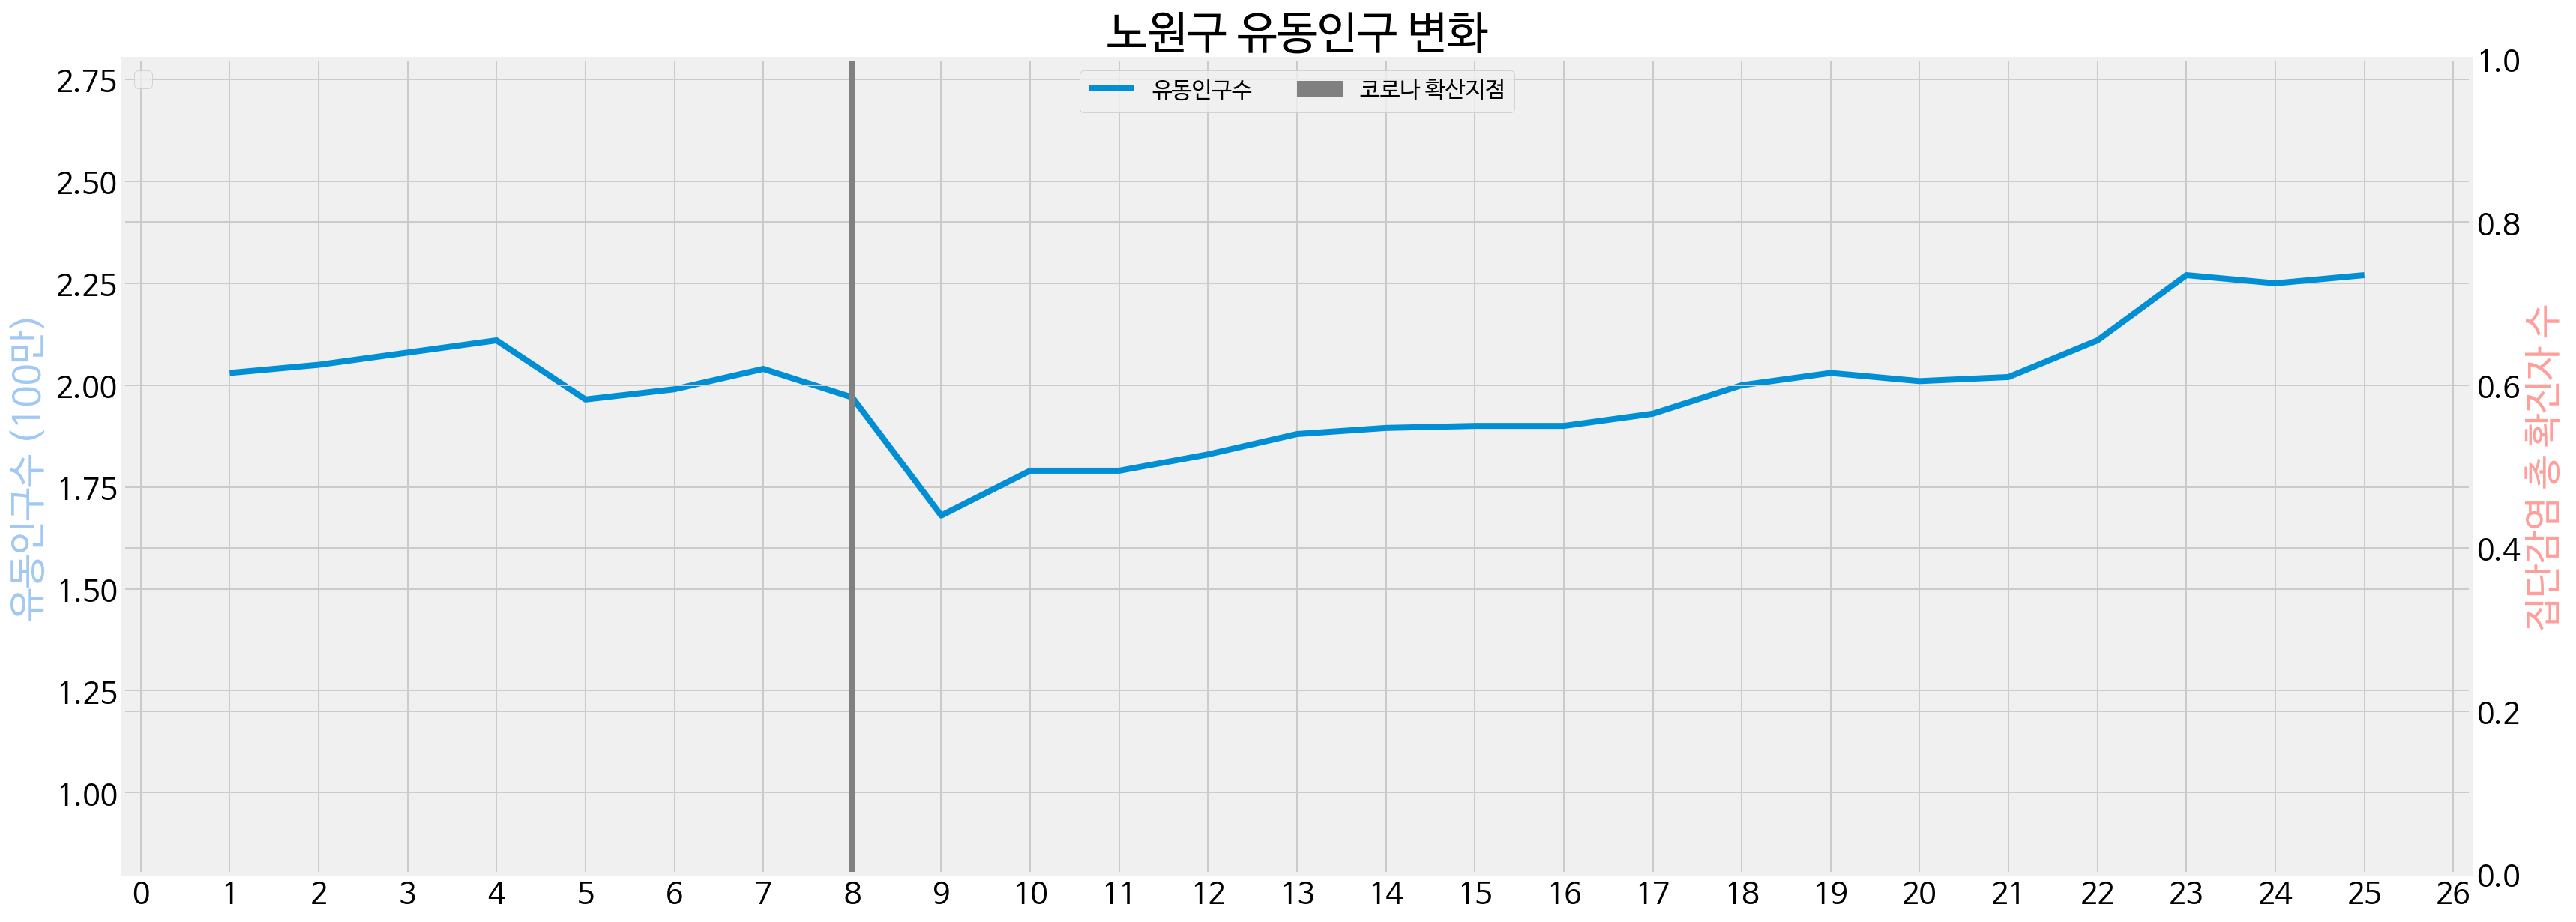

In [ ]:
plot_fpop_gu(new_fpop_seoul_gu,covid_case_seoul_mass_sorted_with_date,time_bin="주차", region="노원구")

delivery_ud = delivery.loc[(delivery['DLVR_STORE_SIGUNGU'].isin(['노원구'])) & (delivery['DLVR_DSTN_SIGUNGU'].isin(['노원구'])),:]
delivery_ud_mean =delivery_ud.groupby(['DLVR_STORE_SIGUNGU','week'])['DLVR_AMOUNT'].mean().reset_index()
delivery_ud_mean['DLVR_AMOUNT'] = delivery_ud_mean['DLVR_AMOUNT']

fig = px.line(delivery_ud_mean, x = 'week', y = 'DLVR_AMOUNT', color = 'DLVR_STORE_SIGUNGU', title='노원구의 평균 배달비용 비교').for_each_trace(lambda t: t.update(name=t.name.replace("DLVR_STORE_SIGUNGU=","")))
fig.show()

2. 영등포구

No handles with labels found to put in legend.


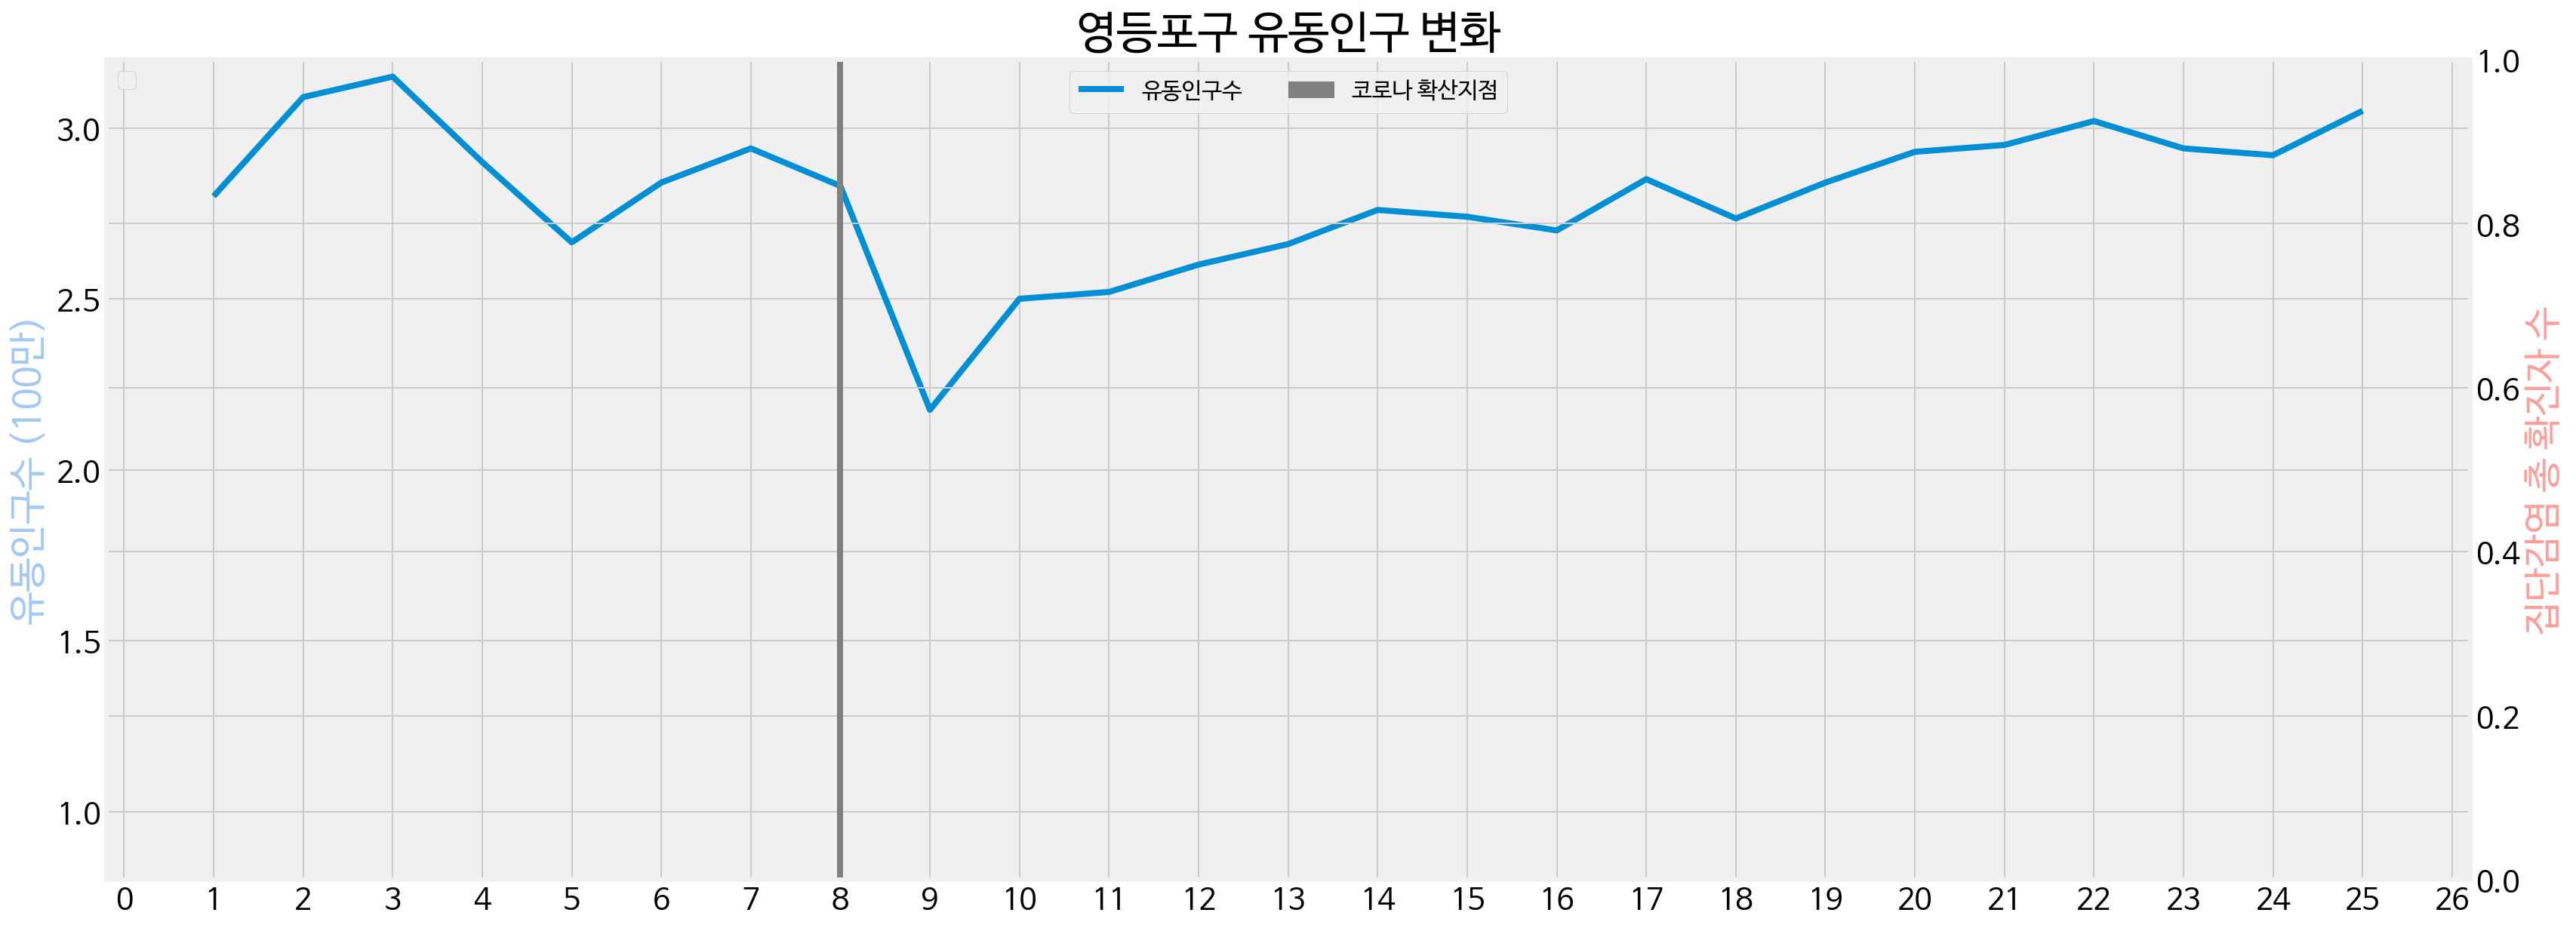

In [ ]:
plot_fpop_gu(new_fpop_seoul_gu,covid_case_seoul_mass_sorted_with_date,time_bin="주차", region="영등포구")

delivery_ud = delivery.loc[(delivery['DLVR_STORE_SIGUNGU'].isin(['영등포구'])) & (delivery['DLVR_DSTN_SIGUNGU'].isin(['영등포구'])),:]
delivery_ud_mean =delivery_ud.groupby(['DLVR_STORE_SIGUNGU','week'])['DLVR_AMOUNT'].mean().reset_index()
delivery_ud_mean['DLVR_AMOUNT'] = delivery_ud_mean['DLVR_AMOUNT']

fig = px.line(delivery_ud_mean, x = 'week', y = 'DLVR_AMOUNT', color = 'DLVR_STORE_SIGUNGU', title='영등포구의 평균 배달비용 비교').for_each_trace(lambda t: t.update(name=t.name.replace("DLVR_STORE_SIGUNGU=","")))
fig.show()

3. 동작구

No handles with labels found to put in legend.


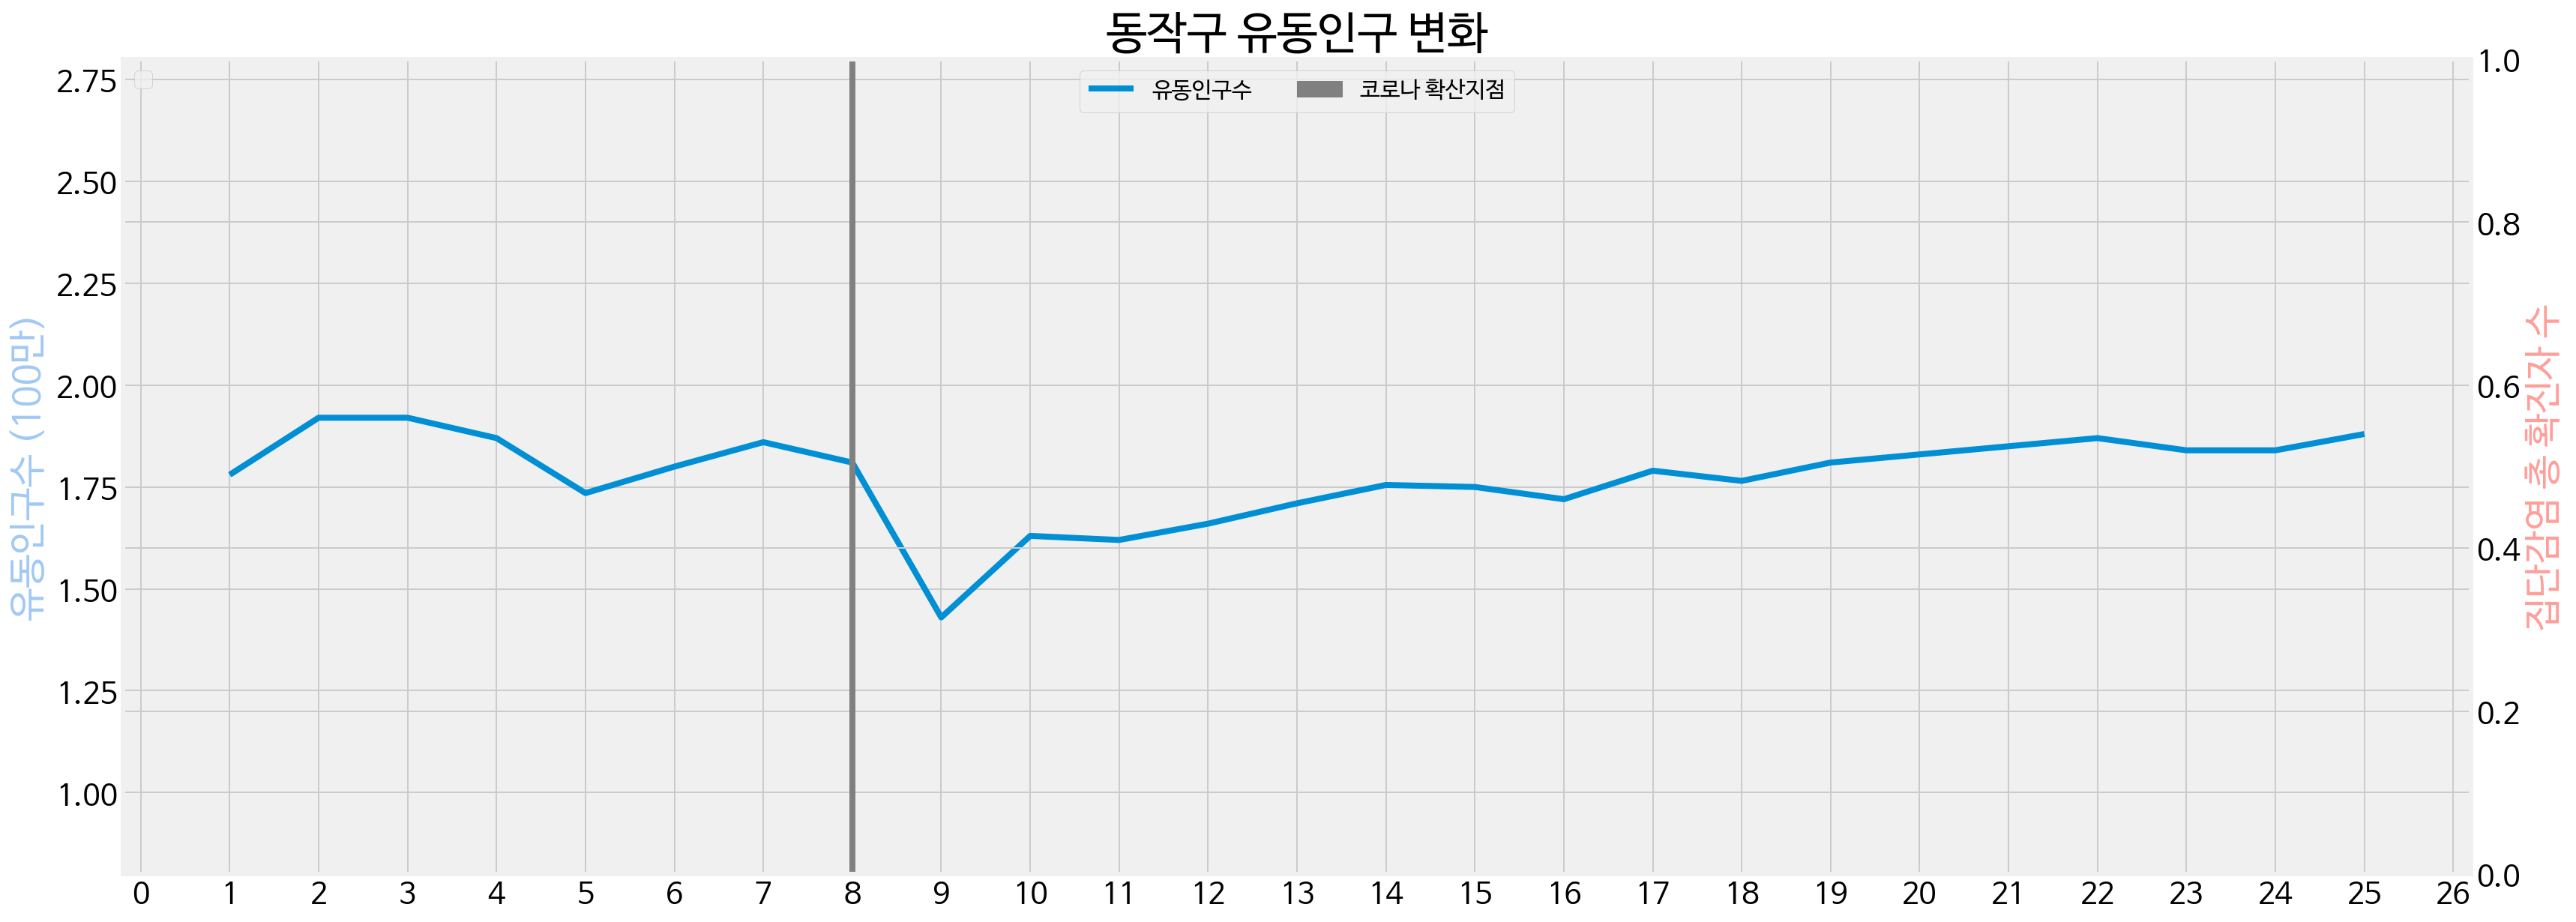

In [ ]:
plot_fpop_gu(new_fpop_seoul_gu,covid_case_seoul_mass_sorted_with_date,time_bin="주차", region="동작구")

delivery_ud = delivery.loc[(delivery['DLVR_STORE_SIGUNGU'].isin(['동작구'])) & (delivery['DLVR_DSTN_SIGUNGU'].isin(['동작구'])),:]
delivery_ud_mean =delivery_ud.groupby(['DLVR_STORE_SIGUNGU','week'])['DLVR_AMOUNT'].mean().reset_index()
delivery_ud_mean['DLVR_AMOUNT'] = delivery_ud_mean['DLVR_AMOUNT']

fig = px.line(delivery_ud_mean, x = 'week', y = 'DLVR_AMOUNT', color = 'DLVR_STORE_SIGUNGU', title='동작구의 평균 배달비용 비교').for_each_trace(lambda t: t.update(name=t.name.replace("DLVR_STORE_SIGUNGU=","")))
fig.show()

집단감염이 발생한 구로구, 관악구, 은평구, 양천구, 도봉구는 집단감염 발생 후  배달 비용이 증가하였다. 그리고 집단감염이 발생하지 않은 노원구와 영등포구등도 배달비용의 다양한 변화를 보여준다. 하지만 집단감염 구들의 데이터만 분석한다면 집단 감염 발병 시기에 배달 비용이 증가하는 것을 확인했기 때문에 집단감염과 배달 비용 또한 어느정도 연관성이 있음을 알 수 있다.